<a href="https://colab.research.google.com/github/nanunzoey/data-science-portfolio/blob/main/semiconductor_manufacturing_anomaly_detection_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **제조 공정 이상 탐지 Manufacturing Anomaly Detection**

A complex modern semiconductor manufacturing process is normally under constant
surveillance via the monitoring of signals/variables collected from sensors and or process measurement points. However, not all of these signals are equally valuable in a specific monitoring system.

![image](https://user-images.githubusercontent.com/80008411/139516620-676ef18f-0b10-4448-bee7-8ef0eca1d403.png)


### 목적 Objective
- To build a classifier to predict the Pass/Fail yield of a particular process entity.
- To analyze whether all the features are required to build the model or not, trying out different combinations of features.

### 데이터 개요 Dataset Description
- [UCI semiconductor manufacturing sensor data.](https://www.kaggle.com/saurabhbagchi/fmst-semiconductor-manufacturing-project/data)
- 1,567 examples each with 591 features.
- Target column '-1' corresponds to a pass and '1' corresponds to a fail.

### Learning Outcomes
- Feature Importance
- Exploratory Data Analysis
- PCA
- Autoencoder
- Logistic Regression
- Xgboost

## Import Libraries

In [1]:
# for basic operations
import numpy as np
import pandas as pd

# for visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.vis_utils import plot_model
%matplotlib inline
sns.set(style="whitegrid")

# for preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from keras import regularizers

# for better model
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

# for modeling
import tensorflow as tf
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import OneClassSVM
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.optimizers import Adam

# for evaluation
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix

# to avoid warnings
import warnings
warnings.filterwarnings("ignore")

np.random.seed(2021)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Reading Data and Understanding the attributes

In [2]:
# for providing path
file_path = '/content/drive/MyDrive/AIFFEL/uci-secom.csv'

In [3]:
data = pd.read_csv(file_path)

print(data.shape)
data.head()

(1567, 592)


,Time,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,...,0.78,0.1827,5.7349,0.3363,39.8842,3.2687,1.0297,1.0344,0.4385,0.1039,42.3877,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,NaN,NaN,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,-0.0148,0.9627,200.5470,0.0,10.1548,414.7347,9.2599,0.9701,191.2872,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,2.0143,7.3900,68.4222,2.2667,0.2102,3.4171,84.9052,9.7997,50.6596,64.2828,49.3404,64.9193,87.5241,...,1.33,0.2829,7.1196,0.4989,53.1836,3.9139,1.7819,0.9634,0.1745,0.0375,18.1087,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0.0096,0.0201,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,0.0013,0.9615,202.0179,0.0,9.5157,416.7075,9.3144,0.9674,192.7035,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,2.0295,7.5788,67.1333,2.3333,0.1734,3.5986,84.7569,8.6590,50.1530,64.1114,49.8470,65.8389,84.7327,...,0.85,0.0857,7.1619,0.3752,23.0713,3.9306,1.1386,1.5021,0.3718,0.1233,24.7524,267.064,0.9032,1.10,0.6219,0.4122,0.2562,0.4119,68.8489,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,0.0584,0.0484,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,100.0,104.2367,0.1217,1.4882,-0.0124,-0.0033,0.9629,201.8482,0.0,9.6052,422.2894,9.6924,0.9687,192.1557,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,2.0038,7.3145,62.9333,2.6444,0.2071,3.3813,84.9105,8.6789,50.5100,64.1125,49.4900,65.1951,86.6867,...,39.33,0.6812,56.9303,17.4781,161.4081,35.3198,54.2917,1.1613,0.7288,0.2710,62.7572,268.228,0.6511,7.32,0.1630,3.5611,0.0670,2.7290,25.0363,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0.0202,0.0149,0.0044,73.8432,0.4990,0.0103,0.0025,2.0544,0.0202,0.0149,0.0044,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,100.0,100.3967,0.1235,1.5031,-0.0031,-0.0072,0.9569,201.9424,0.0,10.5661,420.5925,10.3387,0.9735,191.6037,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,1.9912,7.2748,62.8333,3.1556,0.2696,3.2728,86.3269,8.7677,50.2480,64.1511,49.7520,66.1542,86.1468,...,1.98,0.4287,9.7608,0.8311,70.9706,4.9086,2.5014,0.9778,0.2156,0.0461,22.0500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,NaN,NaN,NaN,NaN,0.4800,0.4766,0.1045,99.3032,0.0202,0.0149,0.0044,73.8432,-1


In [4]:
# check missing values
data.isnull().any().any()

True

In [5]:
# replace all the NaN values with 0
data = data.replace(np.NaN, 0)

# check again
data.isnull().any().any()

False

In [6]:
# check balance of label data
data['Pass/Fail'].value_counts(normalize=True)

-1    0.933631
 1    0.066369
Name: Pass/Fail, dtype: float64

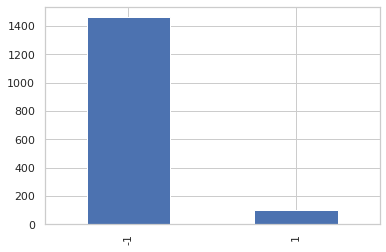

In [7]:
data['Pass/Fail'].value_counts().plot(kind='bar')

## Remove Correlational & Collinear Features

In [8]:
# correlation matrix
corr = data.corr()

# since the correlation is too big so have exported as csv file
corr.to_csv('correlation.csv')

Text(0.5, 1.0, 'Correlation heatmap for the Data')

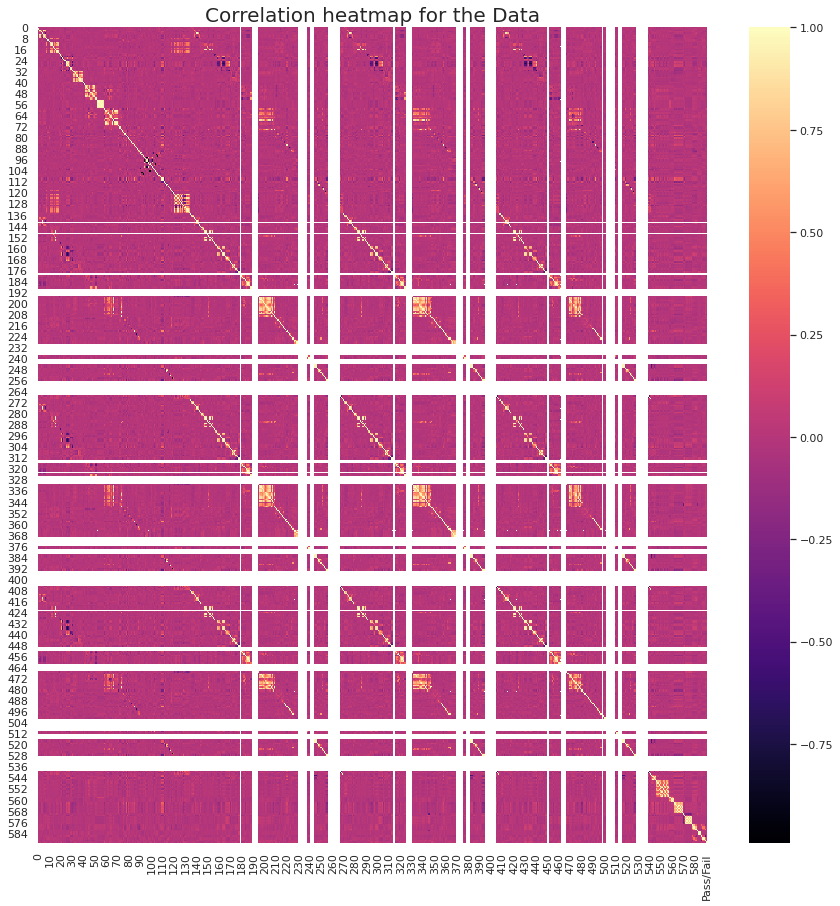

In [9]:
# heatmap to get correlation
plt.rcParams['figure.figsize'] = (15, 15)
sns.heatmap(corr, cmap = "magma")
plt.title('Correlation heatmap for the Data', fontsize = 20)

In [10]:
# based on correlation, a lot of columns are having same value through and no variance which are shown as blank values.
# remove such columns (116 columns)
data.drop(['5','13','42','49','52','69','97','141',
  '149','178','179','186','189','190','191','192',
  '193','194','226','229','230','231','232','233',
  '234','235','236','237','240','241','242','243',
  '256','257','258','259','260','261','262','263',
  '264','265','266','276','284','313','314','315',
  '322','325','326','327','328','329','330','364',
  '369','370','371','372','373','374','375','378',
  '379','380','381','394','395','396','397','398',
  '399','400','401','402','403','404','414','422',
  '449','450','451','458','461','462','463','464',
  '465','466','481','498','501','502','503','504',
  '505','506','507','508','509','512','513','514',
  '515','528','529','530','531','532','533','534',
  '535','536','537','538'], axis=1, inplace=True)

In [11]:
data.shape

(1567, 476)

In [12]:
#Remove the highly collinear features from results dataframe
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model 
        to generalize and improves the interpretability of the model.

    Inputs: 
        x: features dataframe
        threshold: features with correlations greater than this value are removed

    Output: 
        dataframe that contains only the non-highly-collinear features
    '''

    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # Iterate through the correlation matrix and compare correlations
    print('Removing:\n')
    for i in iters:
        for j in range(i+1):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns=drops)

    return x

In [13]:
# Remove columns having more than 0% correlation
# Both positive and negative correlations are considered here
final_data = remove_collinear_features(data, 0.8)

Removing:

6 | 2 | 0.82
12 | 11 | 0.83
17 | 11 | 0.81
18 | 17 | 0.9
26 | 25 | 0.83
27 | 25 | 0.98
30 | 29 | 0.86
34 | 32 | 0.88
35 | 34 | 0.83
38 | 37 | 0.97
39 | 32 | 0.81
39 | 34 | 0.91
39 | 37 | 0.86
39 | 38 | 0.84
46 | 43 | 0.84
50 | 43 | 0.9
50 | 46 | 0.97
54 | 53 | 1.0
55 | 53 | 0.95
55 | 54 | 0.95
56 | 53 | 0.98
56 | 54 | 0.97
56 | 55 | 0.96
57 | 53 | 0.97
57 | 54 | 0.96
57 | 55 | 0.98
57 | 56 | 0.99
58 | 53 | 0.93
58 | 54 | 0.93
58 | 55 | 0.92
58 | 56 | 0.96
58 | 57 | 0.94
61 | 60 | 0.88
65 | 64 | 0.85
66 | 60 | 0.97
66 | 61 | 0.84
68 | 60 | 0.85
68 | 61 | 0.87
68 | 66 | 0.85
70 | 60 | 0.97
70 | 61 | 0.85
70 | 66 | 0.99
70 | 68 | 0.88
73 | 72 | 0.98
96 | 94 | 0.96
98 | 94 | 0.84
98 | 96 | 0.87
101 | 98 | 0.91
104 | 99 | 0.99
105 | 92 | 0.99
106 | 93 | 0.99
110 | 109 | 1.0
111 | 109 | 1.0
111 | 110 | 1.0
123 | 121 | 1.0
124 | 121 | 1.0
124 | 123 | 1.0
127 | 122 | 0.97
131 | 121 | 1.0
131 | 123 | 0.99
131 | 124 | 0.99
132 | 121 | 0.89
132 | 123 | 0.89
132 | 124 | 0.89
132 | 131 |

In [14]:
final_data.shape

(1567, 219)

## Data Visualization

In [15]:
# check unique label data
unique_label = final_data['Pass/Fail'].unique()

targets = [final_data.loc[final_data['Pass/Fail'] == label] for label in unique_label]

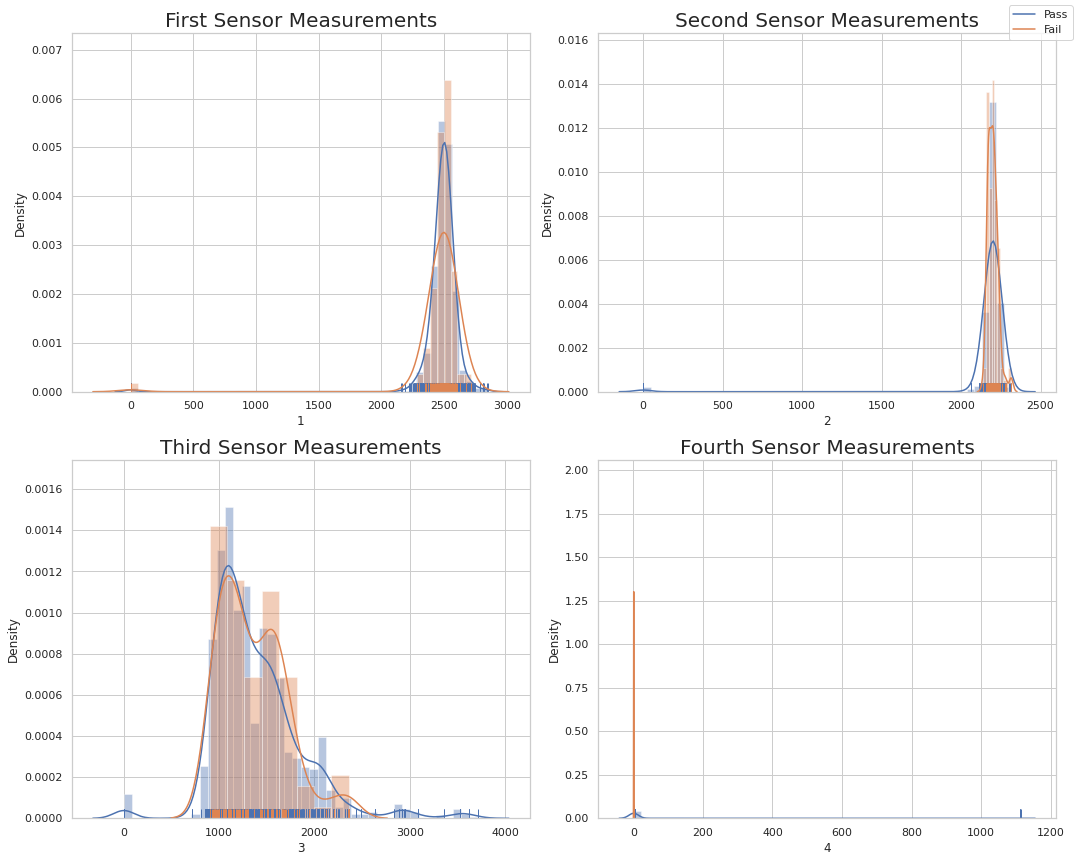

In [16]:
fig = plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
for target in targets:
    sns.distplot(target['1'], hist=True, rug=True)
plt.title('First Sensor Measurements', fontsize=20)

plt.subplot(2, 2, 2)
for target in targets:
    sns.distplot(target['2'], hist=True, rug=True)
plt.title('Second Sensor Measurements', fontsize=20)

plt.subplot(2, 2, 3)
for target in targets:
    sns.distplot(target['3'], hist=True, rug=True)
plt.title('Third Sensor Measurements', fontsize=20)

plt.subplot(2, 2, 4)
for target in targets:
    sns.distplot(target['4'], hist=True, rug=True)
plt.title('Fourth Sensor Measurements', fontsize=20)

fig.legend(labels=['Pass','Fail'])
plt.tight_layout()
plt.show()

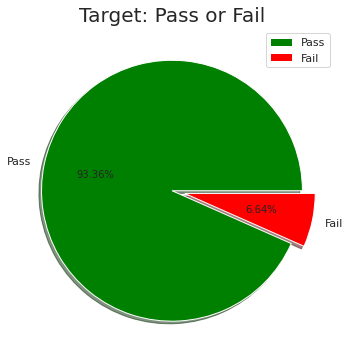

In [17]:
# pie chart
# We have highly imbalanced class with only 6.6% failures and 93.4% pass
labels = ['Pass', 'Fail']
size = final_data['Pass/Fail'].value_counts()
colors = ['green', 'red']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(size, labels=labels, colors=colors, explode=explode, autopct="%.2f%%", shadow=True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize=20)
plt.legend()
plt.show()

Text(0.5, 1.0, 'Correlation heatmap for the Data')

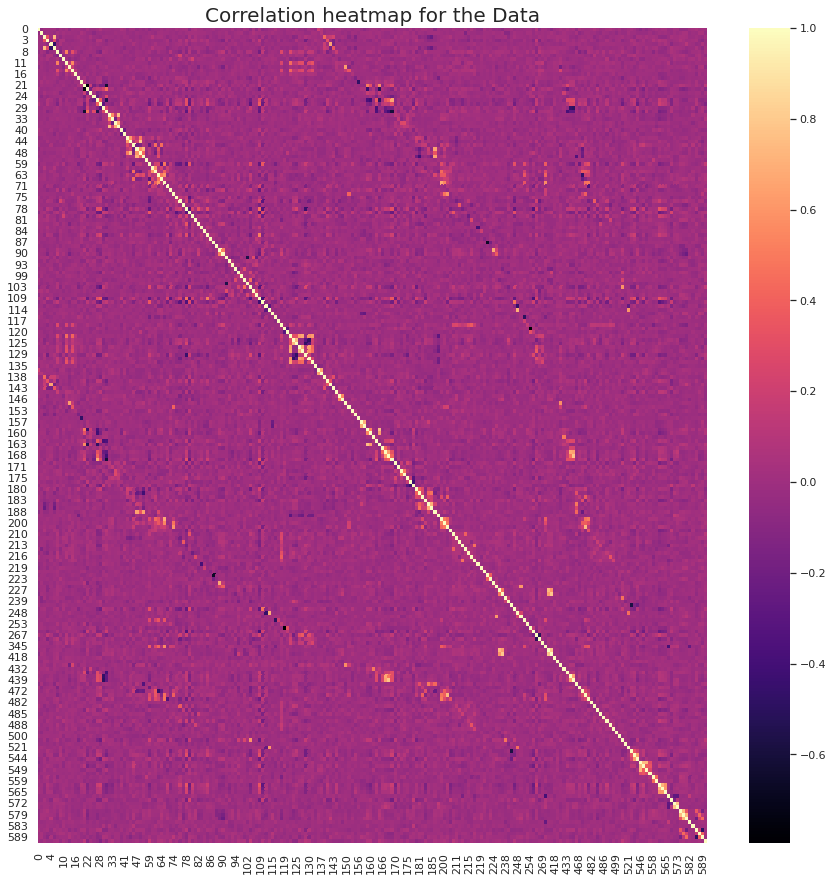

In [18]:
# heatmap to get correlation
plt.rcParams['figure.figsize'] = (15, 15)
sns.heatmap(final_data.corr(), cmap = "magma") #YlGnBu
plt.title('Correlation heatmap for the Data', fontsize = 20)

## Data Scaling

In [19]:
final_data.head()

,Time,0,1,2,3,4,7,8,9,10,11,14,15,16,19,20,21,22,23,24,25,28,29,31,32,33,36,37,40,41,43,44,45,47,48,51,53,59,60,62,...,474,476,482,483,484,485,486,487,488,489,499,500,510,511,521,542,543,544,546,547,549,551,558,559,562,564,565,570,571,572,573,578,579,581,582,583,586,587,589,Pass/Fail
0,2008-07-19 11:55:00,3030.93,2564.00,2187.7333,1411.1265,1.3602,0.1242,1.5005,0.0162,-0.0034,0.9455,7.9558,414.8710,10.0433,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,64.2333,2.0222,3.5191,83.3971,9.5126,49.3830,66.3141,61.29,4.515,352.7173,10.1841,130.3691,1.3072,141.2282,218.3174,4.592,-1.7264,350.9264,108.6427,...,13.6778,31.9893,613.3069,291.4842,494.6996,178.1759,843.1138,0.0000,53.1098,0.0000,0.0000,0.0000,64.6707,0.0000,0.0,0.1096,0.0078,0.0026,1.0616,395.570,0.4234,0.78,1.0344,0.4385,0.000,0.00,0.0000,533.8500,2.1113,8.95,0.3157,0.0000,0.0000,0.0000,0.5005,0.0118,0.0000,0.0000,0.0000,-1
1,2008-07-19 12:32:00,3095.78,2465.14,2230.4222,1463.6606,0.8294,0.1247,1.4966,-0.0005,-0.0148,0.9627,10.1548,414.7347,9.2599,12.4608,1.3825,-5441.50,2604.25,-3498.75,-1640.25,1.2973,68.4222,2.2667,3.4171,84.9052,9.7997,49.3404,64.9193,78.25,2.773,352.2445,10.0373,133.1727,1.2887,145.8445,205.1695,4.590,0.8073,352.0073,113.9800,...,13.2430,30.8643,0.0000,246.7762,0.0000,359.0444,130.6350,820.7900,194.4371,0.0000,0.0000,0.0000,141.4365,0.0000,0.0,0.1096,0.0078,0.0026,1.3526,408.798,0.7193,1.33,0.9634,0.1745,0.000,0.00,0.0000,535.0164,2.4335,5.92,0.2653,0.0096,0.0201,208.2045,0.5019,0.0223,0.0096,0.0201,208.2045,-1
2,2008-07-19 13:17:00,2932.61,2559.94,2186.4111,1698.0172,1.5102,0.1241,1.4436,0.0041,0.0013,0.9615,9.5157,416.7075,9.3144,12.5404,1.4123,-5447.75,2701.75,-4047.00,-1916.50,1.3122,67.1333,2.3333,3.5986,84.7569,8.6590,49.8470,65.8389,14.37,5.434,364.3782,9.8783,131.8027,1.2992,141.0845,185.7574,4.486,23.8245,364.5364,115.6273,...,45.5423,13.3923,434.2674,151.7665,0.0000,190.3869,746.9150,74.0741,191.7582,250.1742,0.0000,0.0000,240.7767,244.2748,0.0,0.1096,0.0078,0.0026,0.7942,411.136,0.1832,0.85,1.5021,0.3718,267.064,1.10,0.6219,535.0245,2.0293,11.21,0.1882,0.0584,0.0484,82.8602,0.4958,0.0157,0.0584,0.0484,82.8602,1
3,2008-07-19 14:43:00,2988.72,2479.90,2199.0333,909.7926,1.3204,0.1217,1.4882,-0.0124,-0.0033,0.9629,9.6052,422.2894,9.6924,12.4782,1.4011,-5468.25,2648.25,-4515.00,-1657.25,1.3137,62.9333,2.6444,3.3813,84.9105,8.6789,49.4900,65.1951,76.90,1.279,363.0273,9.9305,131.8027,1.3027,142.5427,189.9079,4.486,24.3791,361.4582,116.1818,...,48.4887,35.4323,225.0169,100.4883,305.7500,88.5553,104.6660,71.7583,0.0000,336.7660,0.0000,711.6418,113.5593,0.0000,0.0,0.1096,0.0078,0.0026,1.1650,372.822,1.8804,39.33,1.1613,0.7288,268.228,7.32,0.1630,530.5682,2.0253,9.33,0.1738,0.0202,0.0149,73.8432,0.4990,0.0103,0.0202,0.0149,73.8432,-1
4,2008-07-19 15:22:00,3032.24,2502.87,2233.3667,1326.5200,1.5334,0.1235,1.5031,-0.0031,-0.0072,0.9569,10.5661,420.5925,10.3387,12.4735,1.3888,-5476.25,2635.25,-3987.50,117.00,1.2887,62.8333,3.1556,3.2728,86.3269,8.7677,49.7520,66.1542,76.39,2.209,353.3400,10.4091,176.3136,1.0341,138.0882,233.5491,4.624,-12.2945,355.0809,144.0191,...,19.1303,42.6838,171.4486,276.8810,461.8619,240.1781,0.0000,587.3773,748.1781,0.0000,293.1396,0.0000,148.0663,0.0000,0.0,0.1096,0.0078,0.0026,1.4636,399.914,1.0388,1.98,0.9778,0.2156,0.000,0.00,0.0000,532.0155,2.0275,8.83,0.2224,0.0000,0.0000,0.0000,0.4800,0.4766,0.0202,0.0149,73.8432,-1


In [20]:
# drop Time column
final_data.drop('Time', axis=1, inplace=True)

final_data.shape

(1567, 218)

In [21]:
final_X = final_data.drop('Pass/Fail', axis=1)
final_y = final_data['Pass/Fail']

In [22]:
sc = StandardScaler()
sc.fit(final_X)
scaled_X = sc.transform(final_X)

In [23]:
scaled_X.shape

(1567, 217)

In [24]:
final_df = pd.DataFrame(scaled_X)
final_df['Pass/Fail'] = final_y

final_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,Pass/Fail
0,0.139998,0.429208,0.032735,0.059342,-0.049911,0.239971,0.436850,1.128343,-0.381523,-0.481360,-0.365993,0.103291,0.063399,0.115613,-0.146683,0.292325,0.710249,-0.174886,0.361808,-1.680570,-1.216514,-0.817788,-0.271316,-0.637696,0.409564,-0.001649,0.079475,-0.220482,0.510332,-0.237419,0.517576,-0.733509,0.677628,0.234407,0.999689,0.045150,-0.491426,-0.126309,-0.660718,0.309530,...,-0.955990,0.797852,1.064924,0.456406,1.326854,-0.090939,1.896668,-0.895268,-1.159050,-1.171968,-0.809806,-0.745562,0.238101,-0.836511,-0.112621,-0.304202,-0.422665,0.304675,0.370338,0.392696,-0.195969,-0.186148,0.457482,0.560984,-2.171890,-1.556019,-1.305710,0.190142,0.034410,-0.226018,-0.120518,-0.662093,-0.650088,-0.530195,0.055275,-0.204269,-1.734706,-1.868461,-1.061159,-1
1,0.464020,-0.105874,0.236852,0.173847,-0.059375,0.278951,0.393723,0.022511,-1.608226,-0.011526,0.413621,0.097826,-0.257726,0.058404,-1.348004,0.258108,-0.295230,0.218468,-0.462781,0.520326,-0.232288,-0.231388,-0.456551,-0.127751,0.620277,-0.026434,-0.741123,0.450272,-0.222386,-0.280681,0.040723,-0.406395,0.581191,1.038760,0.784205,0.036752,-0.224999,-0.078785,-0.185041,-0.422165,...,-0.973462,0.722641,-1.113864,0.224751,-0.994956,0.737442,-0.581752,2.221206,-0.602090,-1.171968,-0.809806,-0.745562,2.273884,-0.836511,-0.112621,-0.304202,-0.422665,0.304675,0.924510,0.480768,0.250748,0.229177,-0.354020,-0.749637,-2.171890,-1.556019,-1.305710,0.256816,1.205944,-0.261137,-0.323417,0.083539,1.318609,2.327864,0.162312,0.407145,-0.958144,0.412587,1.156951,-1
2,-0.351256,0.407233,0.026413,0.684661,-0.047236,0.232175,-0.192349,0.327111,0.124224,-0.044305,0.187040,0.176936,-0.235386,0.136649,0.433058,0.248603,0.018731,-0.177232,-0.558042,0.601942,-0.535129,-0.071657,-0.126942,-0.177897,-0.216922,0.268308,-0.200098,-2.076132,0.896880,0.829567,-0.475760,-0.566241,0.635925,0.209368,0.466057,-0.399924,2.195341,0.472083,-0.038229,-0.366557,...,0.324410,-0.445433,0.428881,-0.267542,-0.994956,-0.035012,1.562032,-0.614014,-0.612647,-0.077957,-0.809806,-0.745562,4.908328,-0.095153,-0.112621,-0.304202,-0.422665,0.304675,-0.138891,0.496334,-0.558597,-0.133288,5.803114,0.229853,0.501601,-1.234416,5.447531,0.257279,-0.263745,-0.199823,-0.633805,3.873831,4.090457,0.607241,-0.304064,0.022827,2.989383,3.624211,-0.178407,1
3,-0.070903,-0.025985,0.086766,-1.033387,-0.050620,0.045074,0.300837,-0.765478,-0.370762,-0.006063,0.218770,0.400773,-0.080439,0.075508,-0.236334,0.217428,-0.153545,-0.515011,-0.468643,0.610159,-1.521962,0.674474,-0.521564,-0.125959,-0.202317,0.060604,-0.578863,0.396881,-0.850790,0.705958,-0.306198,-0.566241,0.654170,0.463448,0.534080,-0.399924,2.253659,0.336744,0.011190,-0.051340,...,0.442804,1.028031,-0.314486,-0.533240,0.440043,-0.501403,-0.672088,-0.622807,-1.368352,0.300708,-0.809806,1.458969,1.534598,-0.836511,-0.112621,-0.304202,-0.422665,0.304675,0.567250,0.241239,2.003650,28.924325,1.907900,2.002170,0.513254,0.584104,0.464315,0.002548,-0.278290,-0.221613,-0.691776,0.906840,0.809295,0.483463,-0.059408,-0.291614,-0.100689,-0.177535,-0.274469,-1
4,0.146544,0.098340,0.250931,-0.125070,-0.046823,0.185400,0.465600,-0.149655,-0.790424,-0.169959,0.559439,0.332726,0.184487,0.070888,-0.971470,0.205262,-0.195406,-0.134288,0.143182,0.473219,-1.545458,1.900518,-0.718603,0.352978,-0.137143,0.213037,-0.014599,0.376711,-0.459614,-0.180441,1.248447,4.627127,-0.745981,-0.312713,1.249324,0.179512,-1.602699,0.056353,2.492136,1.123988,...,-0.736894,1.512823,-0.504789,0.380740,1.172734,0.193032,-1.036177,1.334957,1.580163,-1.171968,0.093284,-0.745562,2.449703,-0.836511,-0.112621,-0.304202,-0.422665,0.304675,1.135896,0.421618,0.733095,0.720015,-0.189434,-0.545597,-2.171890,-1.556019,-1.305710,0.085279,-0.270290,-0.227409,-0.4

In [25]:
# check unique label data
unique_label = final_df['Pass/Fail'].unique()

targets = [final_df.loc[final_df['Pass/Fail'] == label] for label in unique_label]

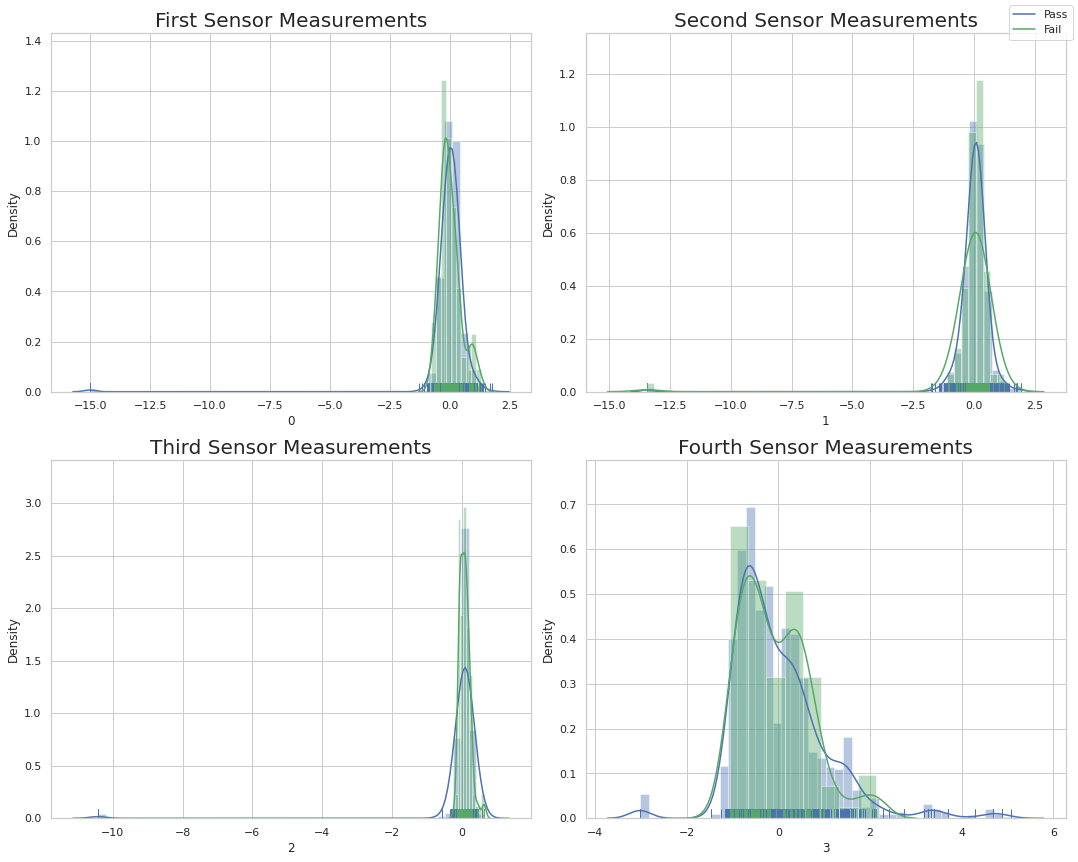

In [26]:
fig = plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
for target in targets:
    sns.distplot(target[0], hist=True, rug=True)
plt.title('First Sensor Measurements', fontsize=20)

plt.subplot(2, 2, 2)
for target in targets:
    sns.distplot(target[1], hist=True, rug=True)
plt.title('Second Sensor Measurements', fontsize=20)

plt.subplot(2, 2, 3)
for target in targets:
    sns.distplot(target[2], hist=True, rug=True)
plt.title('Third Sensor Measurements', fontsize=20)

plt.subplot(2, 2, 4)
for target in targets:
    sns.distplot(target[3], hist=True, rug=True)
plt.title('Fourth Sensor Measurements', fontsize=20)

fig.legend(labels=['Pass','Fail'])
plt.tight_layout()
plt.show()

In [27]:
final_df.shape

(1567, 218)

In [28]:
pass_data = final_df[final_df['Pass/Fail'] == -1]
fail_data = final_df[final_df['Pass/Fail'] == 1]

df = pass_data.append(fail_data).sample(frac=1).reset_index(drop=True)

X = df.drop(['Pass/Fail'], axis=1).values
Y = df["Pass/Fail"].values

## Feature Extraction (1) PCA



Number of dimensions needed to capture 95% of variance: 158


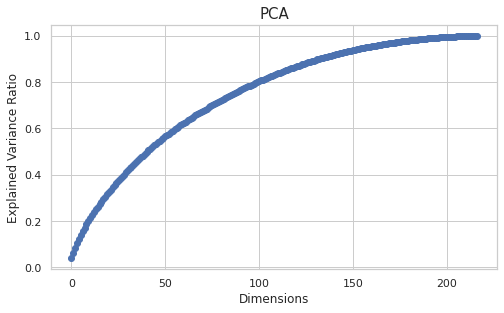

In [29]:
pca = PCA(n_components=X.shape[1]).fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print('Number of dimensions needed to capture 95% of variance:', d)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(cumsum,'-o')
plt.title('PCA', fontsize=15)
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [30]:
# PCA with reduced number of components
pca = PCA(n_components=0.95)
dim_reduced = pca.fit_transform(X)

pca_df = pd.DataFrame(dim_reduced, columns=[f'pc{col}' for col in range(1, d+1)])
pca_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,...,pc119,pc120,pc121,pc122,pc123,pc124,pc125,pc126,pc127,pc128,pc129,pc130,pc131,pc132,pc133,pc134,pc135,pc136,pc137,pc138,pc139,pc140,pc141,pc142,pc143,pc144,pc145,pc146,pc147,pc148,pc149,pc150,pc151,pc152,pc153,pc154,pc155,pc156,pc157,pc158
0,3.866206,-1.481881,-0.067058,0.575872,2.128742,-1.131239,0.765169,0.587809,-1.626930,-0.987244,4.230974,-0.622141,-0.064708,1.593207,-1.940378,0.384084,-1.706922,0.130623,-0.422013,1.057166,-0.883775,-2.174896,1.226764,1.113110,-0.444858,-1.281219,0.790791,-0.356731,-0.874132,1.674561,0.275170,0.647557,1.159645,-0.896269,0.405413,-0.456747,1.206975,0.085937,1.220109,0.117470,...,1.115250,-0.465871,0.659038,-0.207730,-0.360294,0.417037,0.242434,-0.301757,-0.110131,-0.074728,-0.292442,0.376757,0.805111,0.443483,-0.759484,-0.377211,-0.454983,0.004390,-0.053528,0.582394,0.590060,-0.387979,-0.528719,-0.009710,-0.270011,-0.404022,-0.988165,0.378057,1.163953,-0.368388,0.211465,-0.770223,-0.513409,0.649758,-0.405081,1.173300,0.253034,0.243495,0.126770,0.615014
1,1.015424,-2.247937,0.330545,-2.881022,4.458696,-1.941887,-1.973934,0.795318,1.530950,-0.014719,0.048149,3.318397,-0.806579,-0.438954,0.638158,-0.710463,0.487396,-0.367812,1.934302,-0.050593,0.374787,-1.134304,-0.195818,-0.602873,1.652670,-0.520355,0.195894,0.851130,-0.079748,1.340385,-0.266463,-1.135342,-0.036315,0.028443,0.090593,0.038648,-0.591501,0.597506,0.943743,0.006651,...,0.085383,0.630915,0.019485,1.916358,1.031788,-0.601048,-0.039774,0.759383,-1.617110,0.709602,0.369354,-0.114698,-1.843415,0.928334,-0.035172,-0.979195,0.199239,1.338606,-1.276249,0.481915,-0.167042,-1.124837,0.046234,-1.092790,1.598675,-0.128139,-0.110716,0.484865,0.172896,-0.438638,-0.569071,-0.607346,0.846432,0.081817,0.477408,0.416156,-0.539869,-0.239533,0.393714,0.701613
2,1.712071,-2.181346,-0.099640,-3.597884,4.334869,-1.504238,-0.043177,-1.165500,1.896317,1.375939,1.410788,0.435680,-0.680008,-1.770946,-0.490001,2.442435,1.279434,0.990333,-1.481891,-0.803267,-0.120013,0.570639,-0.207318,-0.785587,1.056077,-0.314135,1.844929,0.331661,0.108124,-0.605666,-0.289677,0.280367,-0.029826,0.793715,-0.625011,-0.842988,-0.996276,0.862417,0.602981,1.626258,...,-0.752496,-0.022348,0.072467,0.114870,0.750623,0.524474,-0.672118,0.121157,-0.506897,-0.717165,1.037095,-0.551564,0.071522,-0.960692,1.564146,-0.243172,-0.081204,0.143370,0.134738,-0.169169,-0.425193,-0.146918,0.833065,-0.610024,1.041668,0.671912,-0.533297,0.408267,1.062390,-1.371362,0.078134,0.518408,0.139686,0.649981,0.980174,-0.798088,0.916161,-0.419511,0.353288,0.499160
3,4.077165,-1.553743,0.201736,-0.342842,0.745666,0.445351,-1.611091,-1.346324,-0.145432,0.222806,0.127142,1.569389,-0.534091,-1.958802,0.360690,1.225906,0.040853,1.332314,1.055272,-1.199557,0.972044,1.704435,0.492462,-0.052870,0.772319,-0.700458,0.749524,-1.759634,0.401062,3.082558,-0.377308,0.759572,0.862523,0.511290,-1.335371,-0.217852,-0.741533,-0.939402,-0.479816,1.558243,...,0.315409,-1.409360,-0.021724,0.413029,0.104582,0.721288,-1.145224,0.129156,0.264135,0.413670,0.111256,-0.417150,-1.120265,-0.642732,0.323484,0.469102,1.285392,0.071733,0.481340,-0.045494,-0.021408,-1.275844,0.497559,0.715008,1.000163,-0.018184,0.139505,-0.387449,-0.664900,0.140364,-0.318632,0.234856,-0.745354,-0.464501,-0.234158,-0.991269,0.509802,0.059247,0.265149,0.465522
4,1.770570,1.558700,-0.365619,1.329121,-2.406234,-3.350438,2.671211,0.595475,0.620677,-1.034368,-1.022025,1.307050,-0.186663,-0.175880,0.556571,2.575349,1.274952,-1.963835,1.891691,-2.219914,0.432949,-1.468075,-0.884011,2.366197,-0.574383,-0.328526,-0.357631,-1.185698,0.923312,-2.514340,0.322779,-1.202637,0.364598,-0.195366,-0.272575,0.446280,-0.425869,0.763291,-1.045335,-2.013691,...,-0.794833,0.190606,-1.466636,-0.024997,-0.460694,0.876215,-1.121778,0.324552,-0.068094,-0.299268,-0.678632,-1.107810,0.66998

In [31]:
# Dimension indexing
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4))
components.index = dimensions

components

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216
Dimension 1,0.0241,0.0018,-0.0308,0.0614,0.0248,-0.0298,-0.0709,0.0282,-0.0165,0.0135,-0.0063,-0.0144,-0.0260,0.0346,0.0498,0.0567,-0.0701,-0.0152,-0.0553,0.1943,0.1793,-0.1254,-0.1654,-0.0270,-0.0428,0.0037,-0.0072,0.0508,-0.0373,-0.0094,0.0461,0.0437,0.0126,-0.0000,0.0088,-0.0003,-0.1537,-0.0084,0.0150,-0.0704,...,0.0400,0.0685,-0.0984,-0.0120,0.0557,-0.0829,0.0211,-0.0107,0.0809,-0.0273,-0.0010,0.0117,-0.0021,-0.1211,-0.0186,-0.0059,0.0968,0.1226,-0.0891,0.0293,0.0816,-0.0386,0.0027,0.0208,0.0110,0.1701,0.1317,0.1089,0.0156,-0.0895,0.0220,0.0225,0.0069,0.0035,0.0071,0.0120,-0.0066,0.0460,-0.0121,-0.0232
Dimension 2,-0.0068,-0.0097,0.0063,0.0036,0.0066,0.0118,-0.0175,-0.0201,-0.0047,0.0038,0.0339,0.0276,0.0049,0.0192,-0.0240,-0.0437,0.0313,-0.0193,0.0029,0.0396,0.0236,0.0068,0.0105,0.0448,0.0602,-0.0238,0.0093,-0.0041,-0.0065,0.0531,0.0115,0.1113,0.0151,0.0057,0.0356,0.0181,0.1559,0.1044,0.2798,0.2042,...,0.1324,0.3261,0.2368,0.0149,-0.0428,0.0110,0.0112,-0.0017,-0.0001,-0.0262,-0.0001,-0.0021,-0.0235,-0.0041,0.0371,0.0032,-0.0008,0.0151,-0.0016,0.0136,0.0095,0.0031,0.0165,0.0123,0.0120,0.0016,-0.0025,-0.0012,-0.0121,-0.0196,0.0108,0.0308,0.0046,0.0024,-0.0027,-0.0262,0.0129,-0.0161,0.0033,0.0278
Dimension 3,-0.0183,0.0247,0.0439,0.0261,0.0213,0.0206,-0.0684,-0.0170,0.0557,-0.1145,-0.0179,-0.0966,-0.0523,-0.0383,0.0399,0.2790,-0.2602,0.0617,-0.0575,-0.0913,-0.0966,-0.0166,-0.1705,-0.0133,-0.0089,0.0014,-0.0033,-0.0532,-0.0149,0.0495,0.0303,0.0047,0.0981,0.0700,0.1363,-0.0295,0.0744,0.0113,-0.0266,0.1615,...,-0.1268,0.0377,-0.0096,-0.0132,-0.0110,-0.0757,0.0266,-0.0249,0.0086,-0.0214,-0.0283,0.0022,-0.0164,0.1112,-0.0195,0.0246,0.0116,0.0238,0.0085,0.0189,0.0735,-0.0120,0.0422,-0.0001,0.0075,0.0492,0.0509,0.0512,-0.0047,0.0049,0.0176,0.0252,0.1208,0.1507,0.1310,0.0280,0.0109,0.0029,0.0513,0.0412
Dimension 4,0.0030,-0.0090,-0.0259,0.0222,-0.0061,-0.0162,-0.1741,0.0111,0.0076,-0.2437,-0.0071,-0.2336,-0.0413,0.0100,-0.0490,-0.1411,0.1085,-0.0539,0.0266,-0.0225,0.0149,0.0611,0.1267,-0.0168,-0.0155,-0.0051,-0.0147,0.0384,-0.0074,-0.0159,-0.0574,0.0324,-0.0714,-0.0807,-0.0855,0.0117,-0.0576,0.0047,0.0221,-0.0454,...,0.0492,-0.0043,-0.0147,-0.0454,-0.0014,0.0010,-0.0213,-0.0193,0.0141,-0.0511,-0.0420,0.0093,-0.0111,-0.0310,-0.0089,0.0035,0.0182,-0.0035,0.0019,-0.0003,-0.0018,0.0091,-0.0097,0.0176,-0.0052,-0.0044,0.0021,-0.0040,-0.0081,0.0115,0.0156,0.0214,-0.0125,0.0123,0.0476,-0.0108,0.0015,-0.0659,0.0211,0.0651
Dimension 5,0.0040,-0.0161,-0.0394,-0.0322,-0.0236,-0.0112,-0.0002,-0.0263,0.0248,-0.0787,-0.0983,-0.0756,-0.0304,-0.0021,0.0412,0.0022,0.0712,-0.0009,0.0061,0.1032,0.0234,-0.0936,-0.0624,0.0174,0.0063,-0.0162,0.0049,-0.0124,0.0080,-0.0198,0.0743,-0.1280,0.2083,0.1824,0.1488,-0.0192,0.0332,-0.0622,-0.0659,0.1367,...,-0.0630,-0.0162,0.0523,0.0332,0.0028,0.0221,-0.0054,0.0386,-0.0259,0.0210,0.0336,0.0294,-0.0227,0.0044,-0.0121,-0.0271,-0.0437,0.0081,0.0418,-0.1104,-0.1505,-0.0583,-0.0705,-0.0720,-0.0585,-0.0592,-0.0528,-0.0347,-0.0288,0.0246,0.0447,0.0524,-0.1283,-0.2018,-0.1935,-0.0078,-0.0108,0.0352,-0.1160,-0.0979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dimension 154,-0.0200,-0.0366,0.0210,0.0180,0.0394,-0.0350,-0.0101,-0.0747,0.0383,0.0319,0.0107,-0.0205,0.0050,0.0108,-0.0673,-0.0522,0.0513,-0.0074,-0.1023,-0.0610,-0.0209,-0.1164,0.0261,0.0634,-0.0074,-0.0774,0.0107,-0.0943,-0.0594,0.0144,-0.0149,-0.0215,-0.0025,-0.0176,0.0035,-0.1046,0.0398,0.0049,0.0295,0.0824,...,-0.

In [32]:
# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = dimensions

variance_ratios

,Explained Variance
Dimension 1,0.0397
Dimension 2,0.0223
Dimension 3,0.0219
Dimension 4,0.0206
Dimension 5,0.0185
...,...
Dimension 154,0.0017
Dimension 155,0.0017
Dimension 156,0.0017
Dimension 157,0.0016


Text(0.5, 1.0, 'Principle Components')

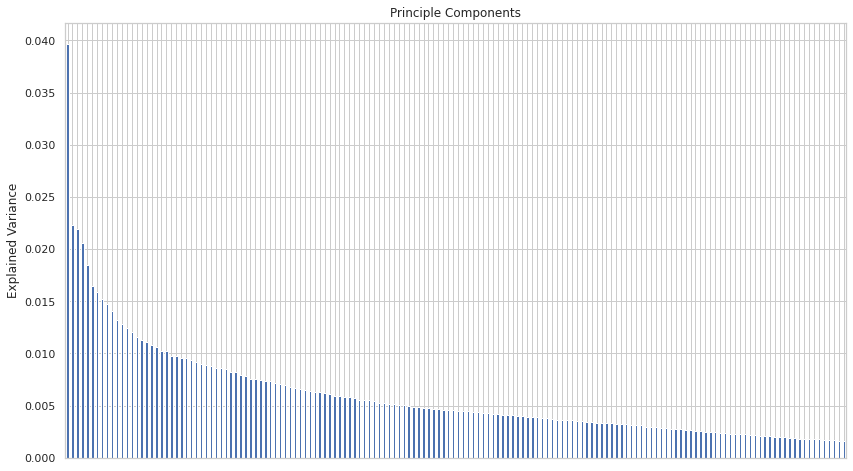

In [33]:
# Create a bar plot visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the feature weights as a function of the components
variance_ratios.plot(ax=ax, kind='bar', legend=False)
ax.set_xticklabels([])
ax.set_ylabel('Explained Variance')
ax.set_title('Principle Components')

# Display the explained variance ratios
# for i, ev in enumerate(pca.explained_variance_ratio_):
#     ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n{:^27.4f}".format(ev))

In [34]:
pca_df.shape

(1567, 158)

In [35]:
pca_df['label'] = Y
pca_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,...,pc120,pc121,pc122,pc123,pc124,pc125,pc126,pc127,pc128,pc129,pc130,pc131,pc132,pc133,pc134,pc135,pc136,pc137,pc138,pc139,pc140,pc141,pc142,pc143,pc144,pc145,pc146,pc147,pc148,pc149,pc150,pc151,pc152,pc153,pc154,pc155,pc156,pc157,pc158,label
0,3.866206,-1.481881,-0.067058,0.575872,2.128742,-1.131239,0.765169,0.587809,-1.626930,-0.987244,4.230974,-0.622141,-0.064708,1.593207,-1.940378,0.384084,-1.706922,0.130623,-0.422013,1.057166,-0.883775,-2.174896,1.226764,1.113110,-0.444858,-1.281219,0.790791,-0.356731,-0.874132,1.674561,0.275170,0.647557,1.159645,-0.896269,0.405413,-0.456747,1.206975,0.085937,1.220109,0.117470,...,-0.465871,0.659038,-0.207730,-0.360294,0.417037,0.242434,-0.301757,-0.110131,-0.074728,-0.292442,0.376757,0.805111,0.443483,-0.759484,-0.377211,-0.454983,0.004390,-0.053528,0.582394,0.590060,-0.387979,-0.528719,-0.009710,-0.270011,-0.404022,-0.988165,0.378057,1.163953,-0.368388,0.211465,-0.770223,-0.513409,0.649758,-0.405081,1.173300,0.253034,0.243495,0.126770,0.615014,-1
1,1.015424,-2.247937,0.330545,-2.881022,4.458696,-1.941887,-1.973934,0.795318,1.530950,-0.014719,0.048149,3.318397,-0.806579,-0.438954,0.638158,-0.710463,0.487396,-0.367812,1.934302,-0.050593,0.374787,-1.134304,-0.195818,-0.602873,1.652670,-0.520355,0.195894,0.851130,-0.079748,1.340385,-0.266463,-1.135342,-0.036315,0.028443,0.090593,0.038648,-0.591501,0.597506,0.943743,0.006651,...,0.630915,0.019485,1.916358,1.031788,-0.601048,-0.039774,0.759383,-1.617110,0.709602,0.369354,-0.114698,-1.843415,0.928334,-0.035172,-0.979195,0.199239,1.338606,-1.276249,0.481915,-0.167042,-1.124837,0.046234,-1.092790,1.598675,-0.128139,-0.110716,0.484865,0.172896,-0.438638,-0.569071,-0.607346,0.846432,0.081817,0.477408,0.416156,-0.539869,-0.239533,0.393714,0.701613,-1
2,1.712071,-2.181346,-0.099640,-3.597884,4.334869,-1.504238,-0.043177,-1.165500,1.896317,1.375939,1.410788,0.435680,-0.680008,-1.770946,-0.490001,2.442435,1.279434,0.990333,-1.481891,-0.803267,-0.120013,0.570639,-0.207318,-0.785587,1.056077,-0.314135,1.844929,0.331661,0.108124,-0.605666,-0.289677,0.280367,-0.029826,0.793715,-0.625011,-0.842988,-0.996276,0.862417,0.602981,1.626258,...,-0.022348,0.072467,0.114870,0.750623,0.524474,-0.672118,0.121157,-0.506897,-0.717165,1.037095,-0.551564,0.071522,-0.960692,1.564146,-0.243172,-0.081204,0.143370,0.134738,-0.169169,-0.425193,-0.146918,0.833065,-0.610024,1.041668,0.671912,-0.533297,0.408267,1.062390,-1.371362,0.078134,0.518408,0.139686,0.649981,0.980174,-0.798088,0.916161,-0.419511,0.353288,0.499160,-1
3,4.077165,-1.553743,0.201736,-0.342842,0.745666,0.445351,-1.611091,-1.346324,-0.145432,0.222806,0.127142,1.569389,-0.534091,-1.958802,0.360690,1.225906,0.040853,1.332314,1.055272,-1.199557,0.972044,1.704435,0.492462,-0.052870,0.772319,-0.700458,0.749524,-1.759634,0.401062,3.082558,-0.377308,0.759572,0.862523,0.511290,-1.335371,-0.217852,-0.741533,-0.939402,-0.479816,1.558243,...,-1.409360,-0.021724,0.413029,0.104582,0.721288,-1.145224,0.129156,0.264135,0.413670,0.111256,-0.417150,-1.120265,-0.642732,0.323484,0.469102,1.285392,0.071733,0.481340,-0.045494,-0.021408,-1.275844,0.497559,0.715008,1.000163,-0.018184,0.139505,-0.387449,-0.664900,0.140364,-0.318632,0.234856,-0.745354,-0.464501,-0.234158,-0.991269,0.509802,0.059247,0.265149,0.465522,-1
4,1.770570,1.558700,-0.365619,1.329121,-2.406234,-3.350438,2.671211,0.595475,0.620677,-1.034368,-1.022025,1.307050,-0.186663,-0.175880,0.556571,2.575349,1.274952,-1.963835,1.891691,-2.219914,0.432949,-1.468075,-0.884011,2.366197,-0.574383,-0.328526,-0.357631,-1.185698,0.923312,-2.514340,0.322779,-1.202637,0.364598,-0.195366,-0.272575,0.446280,-0.425869,0.763291,-1.045335,-2.013691,...,0.190606,-1.466636,-0.024997,-0.460694,0.876215,-1.121778,0.324552,-0.068094,-0.299268,-0.678632,-1.107810,0.669983,-0.635720,0.695301,-0.235774,0.69

In [36]:
pca_df.shape

(1567, 159)

## Feature Extraction (2) TSNE, AutoEncoder

In [37]:
tsne = TSNE(n_components=2, random_state=2021)
tsne_data = tsne.fit_transform(X)

In [38]:
tsne_data

array([[-13.25668  ,   7.0601764],
       [ 15.874011 ,   7.5485196],
       [ 16.584976 ,   3.147684 ],
       ...,
       [ 27.989162 , -56.527966 ],
       [-16.990349 ,  44.56447  ],
       [-36.57848  , -19.840622 ]], dtype=float32)

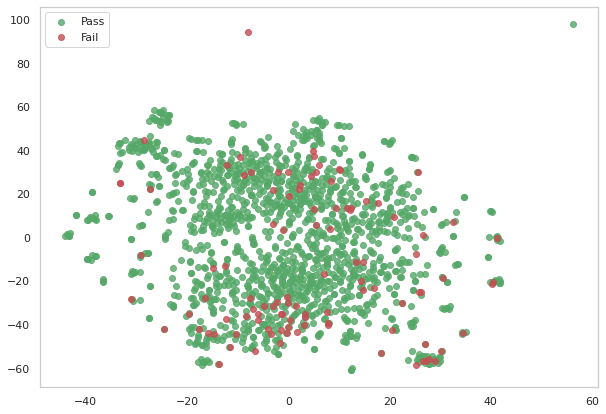

In [39]:
plt.figure(figsize=(10, 7))
plt.scatter(tsne_data[np.where(Y == -1), 0], tsne_data[np.where(Y == -1), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Pass')
plt.scatter(tsne_data[np.where(Y == 1), 0], tsne_data[np.where(Y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fail')

plt.legend(loc='best')
plt.grid()
plt.show()

In [40]:
pass_label = pass_data['Pass/Fail']
fail_label = fail_data['Pass/Fail']

pass_data.drop('Pass/Fail', axis=1, inplace=True)
fail_data.drop('Pass/Fail', axis=1, inplace=True)

In [41]:
# input layer 
input_layer = Input(shape=(pass_data.shape[1],))

# encoding part
encoded = Dense(100, activation='tanh')(input_layer)
encoded = Dense(50, activation='relu')(encoded)

# decoding part
decoded = Dense(50, activation='tanh')(encoded)
decoded = Dense(100, activation='tanh')(decoded)

# output layer
output_layer = Dense(pass_data.shape[1], activation='relu')(decoded)

In [42]:
autoencoder = Model(input_layer, output_layer)

op = Adadelta(lr=0.01)
autoencoder.compile(optimizer=op, loss="mse")

In [43]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 217)]             0         
_________________________________________________________________
dense (Dense)                (None, 100)               21800     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_4 (Dense)              (None, 217)               21917     
Total params: 56,417
Trainable params: 56,417
Non-trainable params: 0
_________________________________________________________

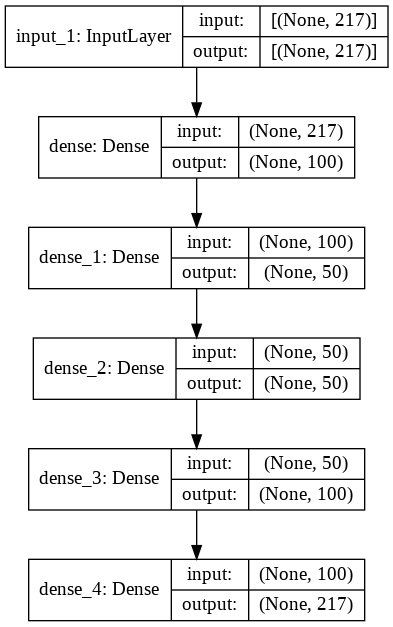

In [44]:
plot_model(autoencoder, show_shapes=True, show_layer_names=True)

In [45]:
history = autoencoder.fit(pass_data, pass_data, batch_size=64, epochs=200, validation_split=0.2, verbose=1)

Epoch 1/200
19/19 [==============================] - 1s 37ms/step - loss: 1.0100 - val_loss: 1.0985
Epoch 2/200
19/19 [==============================] - 0s 4ms/step - loss: 1.0093 - val_loss: 1.0981
Epoch 3/200
19/19 [==============================] - 0s 3ms/step - loss: 1.0086 - val_loss: 1.0978
Epoch 4/200
19/19 [==============================] - 0s 4ms/step - loss: 1.0079 - val_loss: 1.0974
Epoch 5/200
19/19 [==============================] - 0s 4ms/step - loss: 1.0072 - val_loss: 1.0970
Epoch 6/200
19/19 [==============================] - 0s 5ms/step - loss: 1.0066 - val_loss: 1.0966
Epoch 7/200
19/19 [==============================] - 0s 4ms/step - loss: 1.0060 - val_loss: 1.0963
Epoch 8/200
19/19 [==============================] - 0s 4ms/step - loss: 1.0054 - val_loss: 1.0959
Epoch 9/200
19/19 [==============================] - 0s 4ms/step - loss: 1.0048 - val_loss: 1.0956
Epoch 10/200
19/19 [==============================] - 0s 5ms/step - loss: 1.0042 - val_loss: 1.0953
Epoch 11

### Latent Representation Visualization

In [46]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [47]:
pass_hid_rep = hidden_representation.predict(pass_data)
fail_hid_rep = hidden_representation.predict(fail_data)

In [48]:
rep_x = np.append(pass_hid_rep, fail_hid_rep, axis=0)
y_n = np.zeros(pass_hid_rep.shape[0])
y_f = np.ones(fail_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)

In [49]:
tsne = TSNE(n_components=2, random_state=2021)
tsne_data = tsne.fit_transform(rep_x)

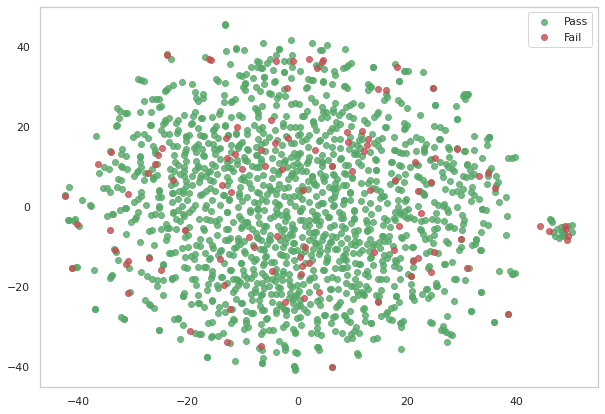

In [50]:
plt.figure(figsize=(10, 7))
plt.scatter(tsne_data[np.where(rep_y == 0), 0], tsne_data[np.where(rep_y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Pass')
plt.scatter(tsne_data[np.where(rep_y == 1), 0], tsne_data[np.where(rep_y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fail')

plt.legend(loc='best')
plt.grid()
plt.show()

## SMOTE

In [51]:
X_sample, y_sample = SMOTE(random_state=2021).fit_sample(X, Y.ravel())

print(X_sample.shape)
print(y_sample.shape)

(2926, 217)
(2926,)


In [52]:
new_df = pd.DataFrame(X_sample)
new_df['Pass/Fail'] = y_sample

new_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,Pass/Fail
0,0.187715,0.147919,0.120768,1.074758,-0.037421,0.271155,1.804720,2.220932,-0.672058,0.185149,-0.274630,-0.640160,0.047822,0.096543,-0.720448,0.465692,-0.349166,-0.168029,-0.087600,0.487461,0.879873,-2.123457,-0.519748,-0.596748,-0.249289,0.129431,0.013759,0.480725,-0.121017,-0.412525,0.239195,-0.331512,0.756862,0.763458,0.791418,0.061945,-0.401657,-0.156888,-0.277569,0.513616,...,-0.720974,-0.389530,-0.064784,-1.053920,1.473336,-0.867541,-1.036177,-0.895268,-0.690549,-0.791382,-0.809806,1.019331,-0.235843,-0.836511,-0.112621,1.106353,2.458919,1.925265,0.857476,0.388701,0.350086,0.191420,-0.376880,-0.567937,0.473651,-0.100033,-0.353372,0.026139,0.814706,-0.214543,-0.513032,0.689364,2.014020,1.618838,0.215831,-0.163508,-0.327186,1.218330,0.606683,-1
1,-0.003451,-0.122545,0.101536,0.979697,-0.042060,0.239971,0.622623,0.512520,0.791378,-0.516871,-1.835701,-0.304683,-0.092081,0.032945,0.044572,0.049383,-0.729139,-0.317071,2.366425,0.445831,0.177600,-0.897653,-0.520656,-0.123660,0.129495,0.302518,-0.131146,0.389762,0.004328,-0.230602,0.763148,-1.411935,1.187958,1.508116,0.896702,0.154319,0.068085,-0.125671,-0.704709,0.484186,...,-0.508552,-0.780406,0.938235,1.458809,-0.047375,0.481241,-1.036177,-0.656208,1.643642,2.167812,-0.809806,-0.745562,-0.611557,-0.836511,-0.112621,-0.636098,-0.230559,-0.019443,-1.651343,-2.241018,-0.835172,-0.775154,-0.706053,-1.105589,0.495895,0.315127,-0.014569,0.163745,0.888154,-0.229727,0.350499,-0.662093,-0.650088,-0.530195,0.177603,-0.477950,2.673905,0.219663,-0.701202,-1
2,-0.220248,0.020563,0.079541,-0.023744,-0.053892,0.224379,-0.800537,0.764147,0.812899,0.130517,-1.867112,-0.060772,-0.311998,0.053784,0.247780,0.419309,-0.520637,0.243729,-4.460206,0.600847,0.908585,-2.443399,-0.625986,-0.254519,-0.506973,0.092080,-0.148502,0.555473,-0.123120,-0.430487,0.623146,-1.210505,1.232267,1.512072,1.224025,-0.030429,-0.059046,-0.234388,-0.658606,0.387588,...,-0.865840,-0.827692,-1.113864,-1.053920,-0.571397,-0.421857,-1.036177,-0.895268,0.395160,-0.229602,-0.809806,-0.745562,0.434132,-0.836511,-0.112621,-0.656841,0.601898,0.304675,-1.651343,-2.241018,-0.835172,-0.775154,-0.191720,2.227060,0.416991,1.028501,0.066874,0.548651,-1.098581,-0.250126,-0.161581,-0.662093,-0.650088,-0.530195,-0.174091,-0.064517,0.255236,-1.142157,-0.784274,-1
3,0.220592,0.251461,0.113118,1.509995,-0.054619,0.310134,-0.612551,1.227670,1.630702,0.070422,-1.881294,-0.638098,0.187234,-0.266961,1.114404,0.211725,-0.379757,-0.071856,-2.074027,0.544427,1.002569,-0.231388,-0.714244,-0.516068,-0.481799,-0.008049,-0.142207,0.542027,0.157012,0.167016,0.734238,-0.688320,-1.017567,0.465034,-0.639900,-0.043025,0.340538,0.198569,0.078923,-1.158858,...,0.978342,-1.030774,-1.113864,-0.092003,-0.994956,-0.530306,0.206484,0.810324,-0.240078,-1.171968,-0.809806,1.754813,0.183023,-0.836511,-0.112621,-0.615354,-0.998982,-1.640033,-0.277910,0.498771,-0.437369,0.168766,-0.581470,0.132053,0.346696,0.847234,0.185237,0.207188,-1.594538,-0.203184,-0.209085,-0.662093,-0.650088,-0.530195,-0.273482,-0.169331,0.311860,-1.210248,-0.818620,-1
4,0.097428,0.124266,0.279832,-0.661309,-0.052626,-0.064069,0.568439,1.572001,0.963547,0.138712,1.877373,0.345863,-0.174760,0.122789,0.450989,-1.233760,-1.411802,0.167404,0.193873,-0.588886,1.180082,-1.190734,1.911181,-0.702517,-0.341617,0.079513,-0.112731,0.556660,-0.075169,0.833062,0.003042,0.596917,0.708383,0.268454,0.994056,0.082939,0.270464,0.397458,1.001267,-0.143610,...,0.980432,-0.167982,0.121051,-0.195195,-0.775822,-0.906988,0.840656,0.365547,-1.368352,-1.171968,-0.809806,-0.745562,-0.589095,-0.836511,-0.112621,-1.009480,0.089617,-0.667679,0.324443,0.477625,-0.165021,-0.110634,0.800371,2.022524,0.588974,1.873441,1.100655,0.069896,0.687444,-0.2239

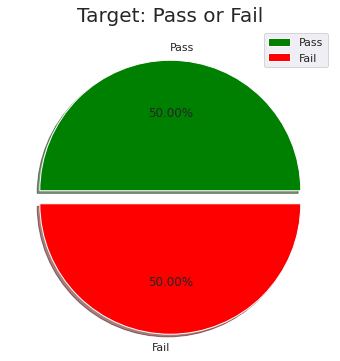

In [99]:
# pie chart
labels = ['Pass', 'Fail']
size = new_df['Pass/Fail'].value_counts()
colors = ['green', 'red']
explode = [0, 0.1]

plt.style.use('seaborn-deep')
plt.rcParams['figure.figsize'] = (6, 6)
plt.pie(size, labels=labels, colors=colors, explode=explode, autopct="%.2f%%", shadow=True)
plt.axis('off')
plt.title('Target: Pass or Fail', fontsize=20)
plt.legend()
plt.show()

In [53]:
new_pass_data = new_df[new_df['Pass/Fail'] == -1]
new_fail_data = new_df[new_df['Pass/Fail'] == 1]

In [54]:
new_pass_label = new_pass_data['Pass/Fail']
new_fail_label = new_fail_data['Pass/Fail']

new_pass_data.drop('Pass/Fail', axis=1, inplace=True)
new_fail_data.drop('Pass/Fail', axis=1, inplace=True)

#### PCA

Number of dimensions needed to capture 95% of variance: 151


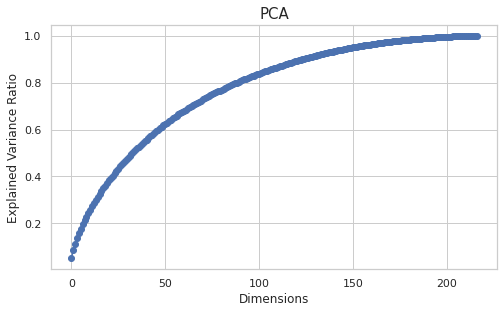

In [55]:
pca = PCA(n_components=X_sample.shape[1]).fit(X_sample)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print('Number of dimensions needed to capture 95% of variance:', d)

fig = plt.figure(figsize=(8, 4.5))
plt.plot(cumsum,'-o')
plt.title('PCA', fontsize=15)
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance Ratio')
plt.show()

In [56]:
# PCA with reduced number of components
pca = PCA(n_components=0.95)
dim_reduced = pca.fit_transform(X_sample)

new_pca_df = pd.DataFrame(dim_reduced, columns=[f'pc{col}' for col in range(1, d+1)])
new_pca_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,...,pc112,pc113,pc114,pc115,pc116,pc117,pc118,pc119,pc120,pc121,pc122,pc123,pc124,pc125,pc126,pc127,pc128,pc129,pc130,pc131,pc132,pc133,pc134,pc135,pc136,pc137,pc138,pc139,pc140,pc141,pc142,pc143,pc144,pc145,pc146,pc147,pc148,pc149,pc150,pc151
0,-3.549456,1.489154,-1.436079,0.097060,0.057702,0.496844,2.815858,1.559374,-0.857072,-0.057769,-0.090656,1.292857,0.151421,-0.724956,1.804347,2.113832,2.262689,0.011291,-0.363291,3.596050,0.613646,-1.262026,-3.225129,-1.770404,0.815909,0.146139,-0.466764,0.065341,0.589302,-0.991678,-0.568448,1.749554,0.594773,1.529363,-0.015695,0.631330,-0.699038,0.214526,-0.626031,-1.396044,...,-0.906606,-0.654047,-0.472950,1.033614,0.318102,0.708784,0.843527,-0.199974,1.071183,-1.223824,-0.139550,-0.309034,1.256609,0.730509,1.562117,0.221737,0.406528,-1.241812,0.568986,-0.357602,0.022522,-0.768808,0.117137,-1.096180,0.105874,-0.102702,-0.641694,0.024153,-0.219688,0.622052,0.368971,-0.677106,1.149370,-0.273447,0.471277,-0.343182,0.609368,-0.042192,-0.502864,0.133719
1,-1.984031,1.030583,-2.855588,3.888148,-0.581050,2.813497,1.044610,-0.788770,-0.017924,-1.379289,-0.751812,0.487405,-1.572380,1.526656,0.243651,1.136952,1.927442,2.472792,-0.692269,-0.848198,0.919364,0.023828,0.995953,-1.640227,-0.449049,1.025806,0.519964,1.473169,0.390254,0.966079,0.325394,-1.402541,0.103377,0.001234,-0.722969,-1.569502,0.404727,1.074142,0.491473,0.463055,...,1.061144,-0.942479,0.368919,0.789306,-0.787211,-0.541482,0.963417,-0.667353,1.134220,0.674892,1.989795,0.372815,-0.355728,0.357127,-0.501850,0.360748,-0.585892,1.421044,-0.686246,0.838629,0.209751,0.668224,-1.030480,0.274118,0.684973,0.391216,0.201104,0.034531,-0.533066,-0.193849,-0.326197,2.029295,0.162579,0.039943,1.714804,0.456013,-0.049741,0.692395,0.645388,-0.499766
2,-1.944078,-0.608140,-2.758328,2.603147,2.209525,3.555406,0.561186,0.358853,-1.759808,0.188769,-1.087616,-0.345251,0.583074,-1.545293,-1.069019,-1.154070,0.228613,1.370788,1.192951,1.222725,-0.318002,-0.841890,0.674106,-0.822829,-0.695689,2.663607,-0.148945,1.307232,-0.566288,1.598396,0.439698,-0.534997,0.535967,-0.576968,1.116096,1.705362,-0.230972,-0.919984,1.973108,0.852960,...,-1.011166,-0.484634,0.457703,0.085942,1.144030,-1.190818,0.599690,-0.419447,0.898012,0.219205,0.228781,-0.349450,-0.160861,-0.788470,-1.059256,0.261328,0.217511,0.771603,-0.340383,0.176948,-0.737320,-0.385103,1.067932,1.013995,0.198746,1.123002,-1.352763,0.224896,-0.405445,0.964364,0.640084,1.774220,-0.861560,0.142545,1.062740,-0.389460,0.169218,0.143854,0.772934,0.945501
3,-4.218810,1.653869,-1.739150,0.408038,0.005537,0.558763,-0.200604,-0.208457,-0.969721,-1.057182,-0.326045,-0.384399,0.847662,1.753900,1.317607,-2.359818,-0.665429,1.679560,-0.686385,0.833335,1.376436,0.546731,-0.547638,-0.169101,-1.337317,1.627401,0.441414,0.112512,-1.016254,1.899591,-1.694138,-0.808992,0.133457,-1.637599,-0.032086,0.338197,-0.731410,0.402451,2.401318,1.150869,...,-0.650001,-0.290494,0.870167,0.161631,1.270675,0.174713,0.347923,0.956040,0.276543,-0.342598,-0.289708,-0.191948,-0.865236,-0.836532,-0.049686,0.401466,-0.400536,0.416712,0.328118,0.384405,-0.191355,0.983727,-0.951329,1.311549,0.719550,-0.009739,0.188615,-0.593808,0.699613,0.188648,-0.093251,0.160503,-0.207093,0.728496,-0.434350,-0.373473,0.320550,-0.162522,0.729652,-0.265994
4,-2.798566,0.226710,0.731749,0.002384,-0.471806,-4.600814,0.038197,-2.024847,0.466836,0.544909,1.163962,-0.970599,1.707917,-2.333948,-1.022064,1.489553,0.056912,-1.613460,1.025653,-0.859679,-0.844028,1.668191,-0.180537,-1.724793,-0.663627,0.193096,0.635848,1.362546,1.514368,0.755141,0.047352,-2.901745,0.939757,-2.164799,-0.275311,0.737688,1.869141,-0.366162,-0.217410,0.278980,...,-0.975400,-0.477839,-1.195603,1.894448,-0.192280,-1.154224,-0.874912,-0.436585,-1.387805,-1.537044,0.306191,0.729742,0.131607,-1.096465,-0

In [57]:
# Dimension indexing
dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

# PCA components
components = pd.DataFrame(np.round(pca.components_, 4))
components.index = dimensions

components

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216
Dimension 1,-0.0283,-0.0053,0.0198,-0.0398,-0.0091,0.0051,0.0263,-0.0386,0.0344,-0.0228,-0.0184,0.0070,0.0044,-0.0274,-0.0064,0.1320,-0.1150,0.0555,0.0232,-0.2478,-0.1779,0.0668,0.0551,0.0154,0.0495,0.0012,0.0116,-0.0495,0.0286,0.0146,-0.0405,0.0018,-0.0409,-0.0254,-0.0221,0.0025,0.1820,0.0110,-0.0296,0.0691,...,-0.0490,-0.0782,0.0742,0.0089,-0.0703,0.0119,-0.0256,-0.0226,-0.0797,-0.0117,-0.0333,0.0050,-0.0062,0.1336,-0.0117,0.0534,-0.0769,-0.0951,0.0707,-0.0165,-0.0353,0.0363,0.0166,0.0159,0.0011,-0.1414,-0.1244,-0.0804,-0.0010,0.0903,-0.0171,-0.0021,0.0486,0.0818,0.0684,-0.0042,0.0095,-0.0257,0.0446,0.0413
Dimension 2,0.0038,0.0462,-0.0031,0.0117,0.0117,0.0014,0.0144,-0.0094,0.0308,0.0139,-0.0367,0.0027,-0.0134,0.0150,0.0499,0.3466,-0.3451,0.1248,-0.0261,-0.1412,-0.0354,-0.1044,-0.1631,-0.0439,-0.0711,0.0251,0.0004,-0.0217,-0.0252,-0.0066,0.0354,0.0209,-0.0052,0.0092,0.0478,-0.0119,-0.0758,-0.0027,0.0048,-0.0631,...,0.0306,0.0188,-0.0343,0.0171,0.0368,-0.0732,0.0136,-0.0118,0.0626,-0.0263,0.0210,0.0349,0.0370,-0.0681,0.0144,0.0443,0.0589,0.0737,-0.0403,0.0541,0.1056,-0.0049,0.0127,0.0440,-0.0002,0.1118,0.0999,0.0825,0.0196,-0.0375,0.0027,-0.0016,0.0726,0.1085,0.0860,0.0215,-0.0045,0.0298,0.0425,-0.0009
Dimension 3,0.0018,0.0006,-0.0086,-0.0429,0.0057,0.0082,-0.0244,-0.0461,-0.0097,0.0073,0.0101,0.0171,-0.0006,0.0160,-0.0290,0.0164,-0.0149,-0.0199,-0.0188,0.0069,0.0079,-0.0070,-0.0062,0.1409,0.2234,-0.0936,0.0197,-0.0166,0.0021,-0.0049,-0.0211,0.1138,-0.0482,-0.0710,-0.0271,0.0366,0.1104,0.0447,0.2129,0.1003,...,0.1587,0.2808,0.2175,0.0096,-0.0751,0.0106,0.0171,-0.0323,0.0040,-0.0223,-0.0104,0.0078,-0.0391,0.0477,0.0426,-0.0120,0.0050,-0.0101,-0.0339,0.0217,0.0144,0.0099,0.0166,0.0053,0.0030,0.0212,0.0339,0.0396,0.0088,-0.0474,-0.0029,0.0291,0.0802,0.0869,0.0485,-0.0038,0.0229,0.0388,0.0536,0.0111
Dimension 4,-0.0196,0.0181,0.0213,0.0409,-0.0069,0.0234,0.0174,0.0052,0.0130,0.0009,-0.0369,0.0100,-0.0047,-0.0108,0.0943,-0.0273,0.0069,0.0464,0.0601,-0.0406,-0.0388,0.0629,0.0256,0.0752,0.1213,-0.0389,0.0222,-0.0031,0.0022,0.0307,0.1124,-0.1926,0.3003,0.2762,0.3286,-0.0643,0.1065,-0.0191,-0.0534,0.1602,...,-0.0612,0.1089,0.0680,0.0742,0.0671,0.0041,-0.0234,-0.0164,-0.0070,-0.0197,0.0833,0.0179,0.0233,-0.0100,-0.0414,-0.0014,0.0368,0.0761,0.0504,-0.1176,-0.1051,-0.0804,-0.0483,-0.0033,0.0590,0.0179,-0.0054,-0.0208,0.0068,-0.0073,-0.0117,-0.0083,0.0114,-0.0471,-0.0652,-0.0057,0.0051,0.0561,-0.0698,-0.0675
Dimension 5,-0.0092,-0.0258,0.0143,0.0044,0.0097,0.0010,-0.0324,-0.0225,-0.0171,-0.0028,-0.0330,-0.0168,-0.0242,-0.0485,0.0427,0.0661,-0.0670,-0.0079,-0.0596,0.1159,-0.0422,-0.0338,-0.1553,-0.0287,-0.0422,0.0263,-0.0061,0.0244,0.0015,0.0279,0.0144,0.0711,0.0649,0.0105,0.0920,-0.0095,-0.0323,0.0104,-0.0968,0.2435,...,-0.2359,-0.0345,-0.0637,0.0041,-0.0191,-0.0897,0.0131,-0.0109,0.0091,-0.0356,0.0354,-0.0349,-0.0209,0.1841,-0.0074,-0.0681,-0.0028,0.0021,-0.0059,0.0380,0.1122,-0.0123,0.0839,-0.0198,0.0778,0.1111,0.0794,0.1271,0.0188,-0.0313,-0.0132,-0.0075,0.0416,0.0505,0.0468,0.0284,0.0181,-0.0079,-0.0113,-0.0068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dimension 147,0.0874,0.0573,-0.0299,0.0900,-0.0037,-0.0290,-0.0120,-0.0091,0.0264,0.0367,-0.0160,0.0665,-0.0046,-0.1443,0.2032,-0.1217,0.1158,-0.0110,0.0497,0.0485,-0.1138,-0.1168,-0.1122,-0.0197,0.0189,0.0041,-0.0136,0.0339,-0.0472,-0.1132,0.0899,-0.0439,0.0210,-0.0028,-0.0667,0.0244,-0.0087,0.0244,0.0252,0.0289,...,0.0518,0.0502,-0

In [58]:
# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns=['Explained Variance'])
variance_ratios.index = dimensions

variance_ratios

,Explained Variance
Dimension 1,0.0515
Dimension 2,0.0345
Dimension 3,0.0271
Dimension 4,0.0233
Dimension 5,0.0212
...,...
Dimension 147,0.0016
Dimension 148,0.0016
Dimension 149,0.0015
Dimension 150,0.0015


Text(0.5, 1.0, 'Principle Components')

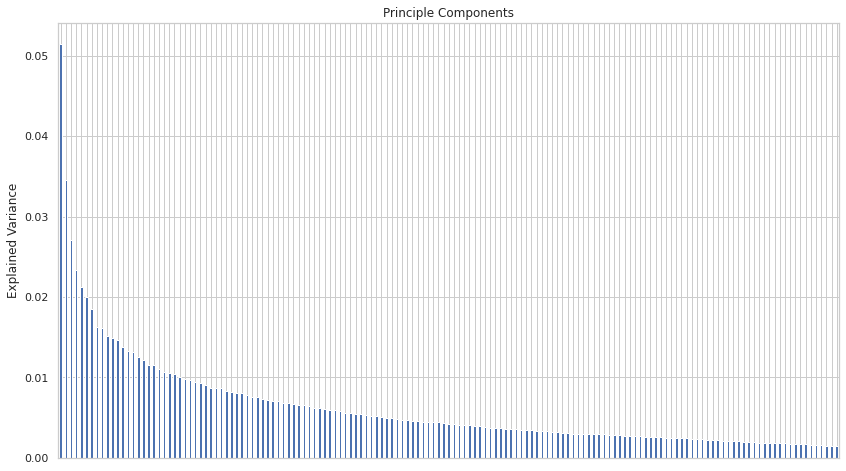

In [59]:
# Create a bar plot visualization
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the feature weights as a function of the components
variance_ratios.plot(ax=ax, kind='bar', legend=False)
ax.set_xticklabels([])
ax.set_ylabel('Explained Variance')
ax.set_title('Principle Components')

# Display the explained variance ratios
# for i, ev in enumerate(pca.explained_variance_ratio_):
#     ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n{:^27.4f}".format(ev))

In [60]:
new_pca_df.shape

(2926, 151)

In [61]:
new_pca_df['label'] = y_sample
new_pca_df.head()

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,...,pc113,pc114,pc115,pc116,pc117,pc118,pc119,pc120,pc121,pc122,pc123,pc124,pc125,pc126,pc127,pc128,pc129,pc130,pc131,pc132,pc133,pc134,pc135,pc136,pc137,pc138,pc139,pc140,pc141,pc142,pc143,pc144,pc145,pc146,pc147,pc148,pc149,pc150,pc151,label
0,-3.549456,1.489154,-1.436079,0.097060,0.057702,0.496844,2.815858,1.559374,-0.857072,-0.057769,-0.090656,1.292857,0.151421,-0.724956,1.804347,2.113832,2.262689,0.011291,-0.363291,3.596050,0.613646,-1.262026,-3.225129,-1.770404,0.815909,0.146139,-0.466764,0.065341,0.589302,-0.991678,-0.568448,1.749554,0.594773,1.529363,-0.015695,0.631330,-0.699038,0.214526,-0.626031,-1.396044,...,-0.654047,-0.472950,1.033614,0.318102,0.708784,0.843527,-0.199974,1.071183,-1.223824,-0.139550,-0.309034,1.256609,0.730509,1.562117,0.221737,0.406528,-1.241812,0.568986,-0.357602,0.022522,-0.768808,0.117137,-1.096180,0.105874,-0.102702,-0.641694,0.024153,-0.219688,0.622052,0.368971,-0.677106,1.149370,-0.273447,0.471277,-0.343182,0.609368,-0.042192,-0.502864,0.133719,-1
1,-1.984031,1.030583,-2.855588,3.888148,-0.581050,2.813497,1.044610,-0.788770,-0.017924,-1.379289,-0.751812,0.487405,-1.572380,1.526656,0.243651,1.136952,1.927442,2.472792,-0.692269,-0.848198,0.919364,0.023828,0.995953,-1.640227,-0.449049,1.025806,0.519964,1.473169,0.390254,0.966079,0.325394,-1.402541,0.103377,0.001234,-0.722969,-1.569502,0.404727,1.074142,0.491473,0.463055,...,-0.942479,0.368919,0.789306,-0.787211,-0.541482,0.963417,-0.667353,1.134220,0.674892,1.989795,0.372815,-0.355728,0.357127,-0.501850,0.360748,-0.585892,1.421044,-0.686246,0.838629,0.209751,0.668224,-1.030480,0.274118,0.684973,0.391216,0.201104,0.034531,-0.533066,-0.193849,-0.326197,2.029295,0.162579,0.039943,1.714804,0.456013,-0.049741,0.692395,0.645388,-0.499766,-1
2,-1.944078,-0.608140,-2.758328,2.603147,2.209525,3.555406,0.561186,0.358853,-1.759808,0.188769,-1.087616,-0.345251,0.583074,-1.545293,-1.069019,-1.154070,0.228613,1.370788,1.192951,1.222725,-0.318002,-0.841890,0.674106,-0.822829,-0.695689,2.663607,-0.148945,1.307232,-0.566288,1.598396,0.439698,-0.534997,0.535967,-0.576968,1.116096,1.705362,-0.230972,-0.919984,1.973108,0.852960,...,-0.484634,0.457703,0.085942,1.144030,-1.190818,0.599690,-0.419447,0.898012,0.219205,0.228781,-0.349450,-0.160861,-0.788470,-1.059256,0.261328,0.217511,0.771603,-0.340383,0.176948,-0.737320,-0.385103,1.067932,1.013995,0.198746,1.123002,-1.352763,0.224896,-0.405445,0.964364,0.640084,1.774220,-0.861560,0.142545,1.062740,-0.389460,0.169218,0.143854,0.772934,0.945501,-1
3,-4.218810,1.653869,-1.739150,0.408038,0.005537,0.558763,-0.200604,-0.208457,-0.969721,-1.057182,-0.326045,-0.384399,0.847662,1.753900,1.317607,-2.359818,-0.665429,1.679560,-0.686385,0.833335,1.376436,0.546731,-0.547638,-0.169101,-1.337317,1.627401,0.441414,0.112512,-1.016254,1.899591,-1.694138,-0.808992,0.133457,-1.637599,-0.032086,0.338197,-0.731410,0.402451,2.401318,1.150869,...,-0.290494,0.870167,0.161631,1.270675,0.174713,0.347923,0.956040,0.276543,-0.342598,-0.289708,-0.191948,-0.865236,-0.836532,-0.049686,0.401466,-0.400536,0.416712,0.328118,0.384405,-0.191355,0.983727,-0.951329,1.311549,0.719550,-0.009739,0.188615,-0.593808,0.699613,0.188648,-0.093251,0.160503,-0.207093,0.728496,-0.434350,-0.373473,0.320550,-0.162522,0.729652,-0.265994,-1
4,-2.798566,0.226710,0.731749,0.002384,-0.471806,-4.600814,0.038197,-2.024847,0.466836,0.544909,1.163962,-0.970599,1.707917,-2.333948,-1.022064,1.489553,0.056912,-1.613460,1.025653,-0.859679,-0.844028,1.668191,-0.180537,-1.724793,-0.663627,0.193096,0.635848,1.362546,1.514368,0.755141,0.047352,-2.901745,0.939757,-2.164799,-0.275311,0.737688,1.869141,-0.366162,-0.217410,0.278980,...,-0.477839,-1.195603,1.894448,-0.192280,-1.154224,-0.874912,-0.436585,-1.387805,-1.537044,0.306191,0.729742,0.131607,-1.096465,-0.382873,-0.618223,-0.316393,-0.016598

In [62]:
new_pca_df.shape

(2926, 152)

#### TSNE, Autoencoder

In [63]:
autoencoder = Model(input_layer, output_layer)

op = Adadelta(lr=100)
autoencoder.compile(optimizer=op, loss="mse")

In [64]:
history = autoencoder.fit(new_pass_data, new_pass_data, batch_size=64, epochs=200, validation_split=0.2, verbose=1)

Epoch 1/200
19/19 [==============================] - 1s 25ms/step - loss: 1.4513 - val_loss: 0.9922
Epoch 2/200
19/19 [==============================] - 0s 4ms/step - loss: 0.9941 - val_loss: 0.9922
Epoch 3/200
19/19 [==============================] - 0s 4ms/step - loss: 0.9941 - val_loss: 0.9922
Epoch 4/200
19/19 [==============================] - 0s 4ms/step - loss: 0.9941 - val_loss: 0.9922
Epoch 5/200
19/19 [==============================] - 0s 4ms/step - loss: 0.9941 - val_loss: 0.9922
Epoch 6/200
19/19 [==============================] - 0s 4ms/step - loss: 0.9941 - val_loss: 0.9922
Epoch 7/200
19/19 [==============================] - 0s 4ms/step - loss: 0.9941 - val_loss: 0.9922
Epoch 8/200
19/19 [==============================] - 0s 4ms/step - loss: 0.9941 - val_loss: 0.9922
Epoch 9/200
19/19 [==============================] - 0s 4ms/step - loss: 0.9941 - val_loss: 0.9922
Epoch 10/200
19/19 [==============================] - 0s 5ms/step - loss: 0.9941 - val_loss: 0.9922
Epoch 11

#### Latent Representation Visualization

In [65]:
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])

In [66]:
pass_hid_rep = hidden_representation.predict(new_pass_data)
fail_hid_rep = hidden_representation.predict(new_fail_data)

In [67]:
new_rep_x = np.append(pass_hid_rep, fail_hid_rep, axis=0)
y_n = np.zeros(pass_hid_rep.shape[0])
y_f = np.ones(fail_hid_rep.shape[0])
new_rep_y = np.append(y_n, y_f)

In [68]:
tsne = TSNE(n_components=2, random_state=2021)
tsne_data = tsne.fit_transform(new_rep_x)

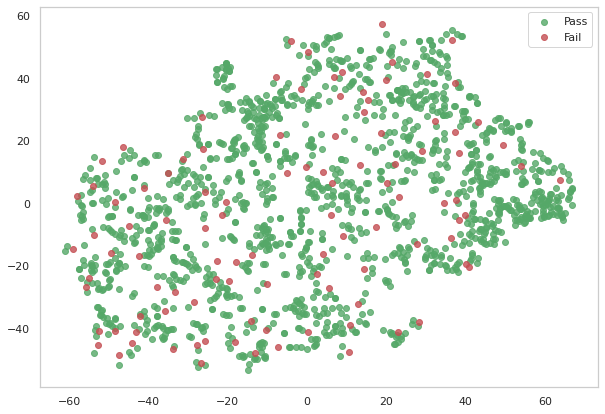

In [69]:
plt.figure(figsize=(10, 7))
plt.scatter(tsne_data[np.where(rep_y == 0), 0], tsne_data[np.where(rep_y == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Pass')
plt.scatter(tsne_data[np.where(rep_y == 1), 0], tsne_data[np.where(rep_y == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Fail')

plt.legend(loc='best')
plt.grid()
plt.show()

## Model Design & Train

- Logistic Regression
- XGboost

### (1) PCA with Normal Data

In [70]:
x_train, x_test, y_train, y_test = train_test_split(pca_df.drop('label', axis=1), pca_df['label'], test_size=0.2, random_state=2021)

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1253, 158)
shape of x_test:  (314, 158)
shape of y_train:  (1253,)
shape of y_test:  (314,)


In [71]:
x_train

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,...,pc119,pc120,pc121,pc122,pc123,pc124,pc125,pc126,pc127,pc128,pc129,pc130,pc131,pc132,pc133,pc134,pc135,pc136,pc137,pc138,pc139,pc140,pc141,pc142,pc143,pc144,pc145,pc146,pc147,pc148,pc149,pc150,pc151,pc152,pc153,pc154,pc155,pc156,pc157,pc158
818,-2.576975,-0.806385,-3.082971,2.234848,-2.214421,0.504749,0.987384,0.374341,-1.529257,1.949030,-1.144031,-0.631083,0.528443,0.407086,0.097499,-0.433099,1.263982,-0.669459,-0.610249,0.358812,1.239341,-0.221179,1.454773,0.838242,0.777149,-1.436654,-0.334977,-0.141249,-0.122074,-0.075475,0.732199,0.487300,-1.066369,0.535812,-1.514327,0.143347,-0.841729,-0.753453,1.353826,1.831078,...,-0.817077,-0.348156,0.596595,-0.790284,0.054178,-0.044831,0.139775,-0.636086,-0.406802,-0.093243,0.539763,0.108833,-0.276511,0.200889,-0.178823,1.090663,0.231343,1.164467,0.189467,-0.346573,-0.013067,0.350741,0.281816,-0.397185,0.267235,0.402835,-0.170637,-0.639069,-0.086917,0.607045,-0.726877,0.312775,0.135322,0.434607,0.665592,-0.378462,0.102790,-0.693614,-0.412511,0.553055
1,1.015424,-2.247937,0.330545,-2.881022,4.458696,-1.941887,-1.973934,0.795318,1.530950,-0.014719,0.048149,3.318397,-0.806579,-0.438954,0.638158,-0.710463,0.487396,-0.367812,1.934302,-0.050593,0.374787,-1.134304,-0.195818,-0.602873,1.652670,-0.520355,0.195894,0.851130,-0.079748,1.340385,-0.266463,-1.135342,-0.036315,0.028443,0.090593,0.038648,-0.591501,0.597506,0.943743,0.006651,...,0.085383,0.630915,0.019485,1.916358,1.031788,-0.601048,-0.039774,0.759383,-1.617110,0.709602,0.369354,-0.114698,-1.843415,0.928334,-0.035172,-0.979195,0.199239,1.338606,-1.276249,0.481915,-0.167042,-1.124837,0.046234,-1.092790,1.598675,-0.128139,-0.110716,0.484865,0.172896,-0.438638,-0.569071,-0.607346,0.846432,0.081817,0.477408,0.416156,-0.539869,-0.239533,0.393714,0.701613
1088,2.837294,-1.775210,0.792235,-0.143374,-1.579998,1.463095,-1.093870,-1.756585,-1.214823,1.175366,0.059475,0.035695,-0.349632,0.434993,-0.179046,0.681316,0.144389,-1.469208,0.451592,-0.396571,1.218710,0.974972,-0.827700,-0.924089,0.117195,-0.987544,1.023759,0.085573,-1.191561,-1.342717,-0.497643,-0.175562,-1.102338,-3.365978,-0.814204,0.212826,-0.474036,-0.586369,0.946073,-1.612292,...,-0.420606,1.386090,0.498110,0.219766,-0.696825,-0.562090,-0.414284,-1.132675,0.344275,-0.038915,-0.270245,-0.433361,-0.397273,0.069686,0.542168,-0.239111,-0.088043,-0.938599,1.027134,0.522631,0.146290,-0.368571,-0.029631,0.103223,-0.481293,0.697683,0.163230,-0.238728,0.637573,-0.125672,0.301383,0.186996,0.059546,-0.308330,-0.375685,-0.648528,0.103828,0.131750,0.469626,0.271702
1090,3.230399,0.874060,1.485776,0.277956,-2.106510,-1.703067,-1.119366,2.144317,0.864650,-1.424293,2.034744,0.794725,1.602513,-0.464510,-1.183869,0.566233,-0.193807,0.014611,1.674375,0.662532,-2.058118,-0.652427,-0.582242,1.354224,-0.748818,-0.256639,0.327949,0.698278,1.241447,0.931990,0.719646,-1.886671,0.893247,-1.127432,-0.343969,-0.309899,-0.399152,1.829992,-2.085106,-0.295031,...,-0.918534,-0.320431,0.492462,-0.485764,0.779374,0.513801,-0.822928,-1.118808,0.350975,-0.770368,0.858654,-0.123322,-0.161969,-0.764290,-0.976210,0.458016,0.681813,-0.533004,-0.692746,-0.981581,-0.925363,-0.333061,-0.552811,0.979709,-0.285810,0.865891,-0.538632,0.084874,-0.339936,-0.563684,0.200430,-0.689835,0.494984,1.154495,-0.854936,0.335336,-0.194282,-0.455153,0.747642,0.160323
1344,2.527919,-1.670952,-0.353821,-0.084468,-1.853613,0.003218,-0.362549,0.897033,-2.017474,0.322990,0.912984,-0.202658,-2.510496,0.284295,0.074576,0.562241,-0.490302,-1.090158,1.096407,-0.215241,0.258354,1.126656,0.562995,-0.277456,-0.398625,-0.661803,-0.534389,0.315787,-0.645784,-0.290737,0.463414,-1.543879,0.410369,-2.016596,1.942925,0.605940,1.108402,1.084727,-0.574550,0.263964,...,0.354185,-1.452576,-1.606352,0.005517,-0.249715,-0.580520,0.712519,-0.127485,0.486713,-1.217640,0.052

In [72]:
pca_lr_model = LogisticRegression(random_state=2021)

In [73]:
pca_lr_model.fit(x_train, y_train) 
y_pred = pca_lr_model.predict(x_test)

In [74]:
def evaluate_model(model, y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.rcParams['figure.figsize'] = (5, 5)
  sns.set(style='dark', font_scale=1.0)
  sns.heatmap(cm, annot=True, fmt='d', annot_kws={"size": 20}, square=True, cmap='Set3')

  print(f"{model}\nAccuracy: {model.score(x_test, y_test)*100:.2f}%\n")
  print(f'F1 score: {f1_score(y_test, y_pred):.2f}\n')

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2021, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 92.68%

F1 score: 0.15



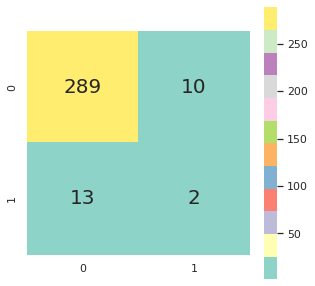

In [75]:
evaluate_model(pca_lr_model, y_test, y_pred)

In [76]:
pca_xb_model = XGBClassifier(random_state=2021)

In [77]:
parameters = [{'learning_rate': [100, 10, 1, 0.1, 0.01], 'max_depth' : [1, 2, 3, 4, 5, 6], 'cv' : [2, 4, 6, 8, 10]}]

grid_search = GridSearchCV(estimator=pca_xb_model, param_grid=parameters, scoring='accuracy', n_jobs=-1)

grid_search = grid_search.fit(x_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

Best Accuracy:  92.89721115537847
Best Parameter:  {'cv': 2, 'learning_rate': 100, 'max_depth': 4}


In [78]:
pca_xb_model = XGBClassifier(cv=2, learning_rate=100, max_depth=4, random_state=2021)
pca_xb_model.fit(x_train, y_train)
y_pred = pca_xb_model.predict(x_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, cv=2, gamma=0,
              learning_rate=100, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2021,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 4.78%

F1 score: 0.09



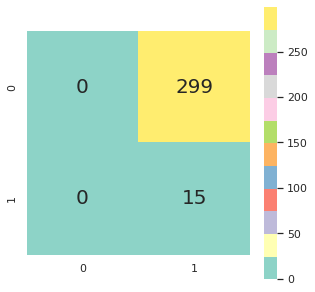

In [79]:
evaluate_model(pca_xb_model, y_test, y_pred)

### (2) TSNE, AutoEncoder with Normal Data

In [80]:
x_train, x_test, y_train, y_test = train_test_split(rep_x, rep_y, test_size=0.2)

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (1253, 50)
shape of x_test:  (314, 50)
shape of y_train:  (1253,)
shape of y_test:  (314,)


In [81]:
ae_lr_model = LogisticRegression(random_state=2021)

ae_lr_model.fit(x_train, y_train) 
y_pred = ae_lr_model.predict(x_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2021, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 92.68%

F1 score: 0.00



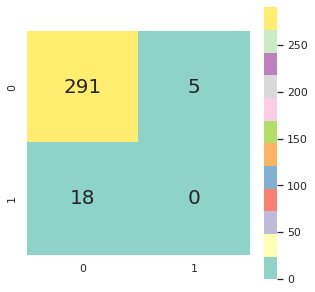

In [82]:
evaluate_model(ae_lr_model, y_test, y_pred)

In [83]:
au_xb_model = XGBClassifier(cv=2, learning_rate=100, max_depth=4, random_state=2021)

au_xb_model.fit(x_train, y_train)
y_pred = au_xb_model.predict(x_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, cv=2, gamma=0,
              learning_rate=100, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2021,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 94.27%

F1 score: 0.00



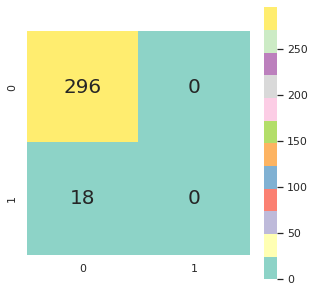

In [84]:
evaluate_model(au_xb_model, y_test, y_pred)

### (3) PCA with SMOTE Data

In [85]:
x_train, x_test, y_train, y_test = train_test_split(new_pca_df.drop('label', axis=1), new_pca_df['label'], test_size=0.2, random_state=2021)

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (2340, 151)
shape of x_test:  (586, 151)
shape of y_train:  (2340,)
shape of y_test:  (586,)


In [86]:
x_train

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,...,pc112,pc113,pc114,pc115,pc116,pc117,pc118,pc119,pc120,pc121,pc122,pc123,pc124,pc125,pc126,pc127,pc128,pc129,pc130,pc131,pc132,pc133,pc134,pc135,pc136,pc137,pc138,pc139,pc140,pc141,pc142,pc143,pc144,pc145,pc146,pc147,pc148,pc149,pc150,pc151
2563,2.217787,-0.752694,1.213753,-4.293279,1.744831,-1.726178,0.135862,0.708790,-0.785646,-0.076989,-1.758517,-1.039899,1.627731,-0.053593,-0.267437,0.307382,1.002658,-1.712327,0.841615,1.072360,0.297787,-1.132317,0.095009,-3.369483,-1.516557,3.292757,-0.197919,-0.483785,0.209120,-0.833286,-2.270415,-0.350748,2.352327,-1.173913,-0.895512,0.004932,0.071289,0.550999,0.791750,-1.930137,...,-0.287822,0.524314,0.505439,0.289785,-0.430507,0.153882,-0.667405,0.346306,-0.190257,-1.134610,-1.100755,0.179927,0.454522,-0.772614,-0.138359,-0.112519,0.171790,-0.042012,0.307388,0.278509,-0.388125,0.392463,0.350341,-1.192539,-0.587146,-0.927462,-0.279612,0.137018,0.052590,0.339567,-0.604801,0.209165,-0.435894,-0.202208,0.599724,0.295655,-0.798583,0.607323,0.097669,0.057884
1867,-1.371098,0.904080,-3.066056,3.712000,0.977591,0.925542,-0.126971,-0.526983,-1.872205,1.005962,-1.600143,0.886582,0.267487,0.378618,-0.596757,-1.634423,0.148314,2.182012,-0.552540,0.963975,1.137887,-1.536392,0.361607,0.357807,-1.724163,2.624836,-1.706942,-0.321222,-1.600181,-2.030745,-1.191241,-1.215212,0.107318,-0.164255,-1.572869,0.606687,-0.306601,-0.133993,0.305918,0.188499,...,0.086954,0.424717,-0.032614,-0.126922,0.304532,-0.479056,-0.036503,0.837931,-0.122988,0.019079,0.232624,-0.205701,0.602594,-0.251993,0.044644,-0.446034,0.069535,-0.350937,-0.200314,0.074072,0.045963,0.676399,-0.175032,0.165599,0.132801,0.068441,0.880717,-0.019980,0.027650,-0.065555,0.019826,0.135478,-0.334542,-0.283761,0.136779,0.022020,0.032567,-0.478176,-0.220712,0.268181
1498,-3.336185,0.879680,0.107100,1.228371,0.620654,0.355978,0.356573,-1.071133,-0.019529,0.095928,-0.607360,1.088416,1.059961,0.078090,-1.002096,0.594408,-1.934392,-1.636918,-0.768213,-0.641788,0.476072,1.530497,1.714075,-0.742216,-0.941151,0.558360,1.012535,-1.677312,-1.423292,-0.382459,-0.479142,-2.105279,3.122964,-0.146552,-2.125072,2.073654,-0.020625,1.399614,-0.474375,-1.684836,...,-0.877919,0.135310,-1.428319,-0.049969,0.860331,0.835743,0.659881,1.159271,-0.659648,-0.776785,-0.062297,-0.332131,0.486983,-0.358303,0.384901,-1.025662,1.903277,-0.959917,1.090233,0.639500,1.351941,-2.177131,0.157038,0.291887,-0.579897,-0.480651,-0.527141,0.266898,0.842601,-0.029008,-1.118113,0.857012,-1.029356,0.025919,-1.692680,-0.615134,1.094079,-0.357504,-1.243090,0.564132
12,1.288787,-2.407642,-1.710489,2.045535,-1.332923,-1.954502,-0.769671,0.249041,-2.143178,-2.439555,0.781583,0.781062,-0.305747,-2.117372,0.410238,3.165129,-3.299750,2.119715,-3.036648,-0.445921,0.350817,-2.045351,0.547894,-2.448553,0.764606,-3.237791,0.043849,-0.789060,0.616659,-0.000795,0.158029,-0.497724,0.478211,-0.239073,-2.411361,1.213460,-0.465978,0.493866,1.414606,-1.314942,...,-0.366242,0.150399,0.313275,-0.142971,0.486629,-0.900908,0.684079,-0.599052,-0.571173,1.220101,0.951722,-1.385829,0.326203,-0.555707,1.307209,0.433359,-0.767045,-0.372330,0.058387,-0.639076,0.645915,0.278404,0.354782,0.721076,-0.727846,-0.445789,-0.424489,0.148839,0.189732,-0.286695,0.239295,-0.353175,-0.270391,-1.463246,0.316232,-0.253128,-0.334192,-0.035414,0.670599,0.006127
1983,-0.416295,-2.457070,0.530828,-2.525048,-5.009641,-1.133215,1.461624,-0.889132,-1.439490,-0.953964,-4.279898,1.034645,1.418044,-2.427606,2.266145,-0.194178,-0.625776,0.141570,4.651835,-0.529601,0.703396,-1.934528,0.431782,1.625197,-0.343455,0.246529,2.139206,0.818032,-0.992290,-0.122920,-0.246836,-0.470908,0.590295,0.615471,1.621918,0.357774,-0.385569,-0.524920,0.579801,0.846534,...,0.159032,-0.389419,0.236084,0.174399,0.301364,0.208157,-0.191760,0.339874,-0.253706,-0.430992,-0.0

In [87]:
pca_lr_model = LogisticRegression(random_state=2021)

In [88]:
pca_lr_model.fit(x_train, y_train) 
y_pred = pca_lr_model.predict(x_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2021, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 87.20%

F1 score: 0.88



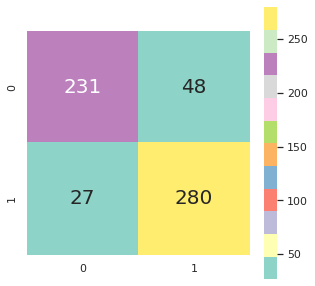

In [89]:
evaluate_model(pca_lr_model, y_test, y_pred)

In [90]:
pca_xb_model = XGBClassifier(random_state=2021)

In [91]:
parameters = [{'learning_rate': [100, 10, 1, 0.1, 0.01], 'max_depth' : [1, 2, 3, 4, 5, 6], 'cv' : [2, 4, 6, 8, 10]}]

grid_search = GridSearchCV(estimator=pca_xb_model, param_grid=parameters, scoring='accuracy', n_jobs=-1)

grid_search = grid_search.fit(x_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Best Accuracy: ", best_accuracy*100)
print("Best Parameter: ", best_parameters)

Best Accuracy:  99.44444444444444
Best Parameter:  {'cv': 2, 'learning_rate': 0.1, 'max_depth': 6}


In [92]:
pca_xb_model = XGBClassifier(cv=2, learning_rate=0.1, max_depth=6, random_state=2021)
pca_xb_model.fit(x_train, y_train)
y_pred = pca_xb_model.predict(x_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, cv=2, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2021,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 99.83%

F1 score: 1.00



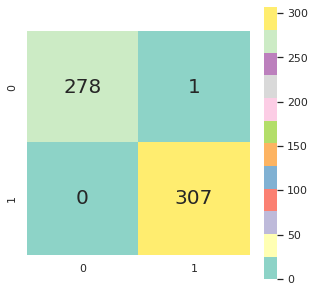

In [93]:
evaluate_model(pca_xb_model, y_test, y_pred)

### (4) TSNE, AutoEncoder with SMOTE Data

In [94]:
x_train, x_test, y_train, y_test = train_test_split(new_rep_x, new_rep_y, test_size=0.2)

print("shape of x_train: ", x_train.shape)
print("shape of x_test: ", x_test.shape)
print("shape of y_train: ", y_train.shape)
print("shape of y_test: ", y_test.shape)

shape of x_train:  (2340, 50)
shape of x_test:  (586, 50)
shape of y_train:  (2340,)
shape of y_test:  (586,)


In [95]:
ae_lr_model = LogisticRegression(random_state=2021)

ae_lr_model.fit(x_train, y_train) 
y_pred = ae_lr_model.predict(x_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=2021, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy: 68.60%

F1 score: 0.70



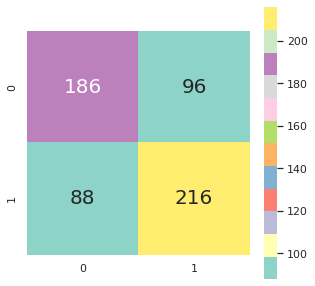

In [96]:
evaluate_model(ae_lr_model, y_test, y_pred)

In [97]:
au_xb_model = XGBClassifier(cv=2, learning_rate=0.1, max_depth=6, random_state=2021)

au_xb_model.fit(x_train, y_train)
y_pred = au_xb_model.predict(x_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, cv=2, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=2021,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 87.71%

F1 score: 0.88



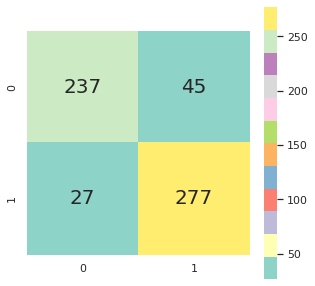

In [98]:
evaluate_model(au_xb_model, y_test, y_pred)